# LOAD

In [2]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import center_of_mass, label, binary_dilation
from nilearn import plotting
import pandas as pd

print("✓ Imports loaded")

✓ Imports loaded


In [4]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {
        'code': 'UD', 
        'sessions': ['01', '02', '03', '05', '06'],
        'hemi': 'l'
    },
    'sub-021': {
        'code': 'TC', 
        'sessions': ['01', '02', '03'],
        'hemi': 'r'
    }
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10,
    'word': 12,
    'object': 3,
    'house': 11
}

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Subjects: {list(SUBJECTS.keys())}")

Base directory: /user_data/csimmon2/long_pt
Output directory: /user_data/csimmon2/long_pt/analyses/rsa_corrected
Subjects: ['sub-004', 'sub-021']


In [34]:
# CELL 3: Quick verification
for subj_id, info in SUBJECTS.items():
    print(f"\n{info['code']} ({subj_id}):")
    print(f"  Sessions: {info['sessions']}")
    print(f"  Hemisphere: {info['hemi']}")
    
    # Check first session exists
    ses01_dir = BASE_DIR / subj_id / 'ses-01'
    print(f"  ses-01 exists: {ses01_dir.exists()}")


UD (sub-004):
  Sessions: ['01', '02', '03', '05', '06']
  Hemisphere: l
  ses-01 exists: True

TC (sub-021):
  Sessions: ['01', '02', '03']
  Hemisphere: r
  ses-01 exists: True


In [26]:
# Cell 1: Extraction function for anatomical parcel
def extract_contrast_values(subject_id, roi_type, use_anatomical_only=False):
    """Extract face-word or object-house contrast from ROI"""
    hemi = SUBJECTS[subject_id]['hemi']
    
    if use_anatomical_only:
        # Liu's approach - full anatomical mask
        if roi_type == 'face_word':
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        else:
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        roi_label = "Anatomical"
    else:
        # Your approach - functionally restricted
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
        roi_label = "Functional"
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    n_voxels = np.sum(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, n_voxels, roi_label

def compare_sessions_both_approaches(subject_id, roi_type='face_word'):
    """Compare both ROI approaches"""
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_name}")
    print(f"{'='*80}")
    
    for use_anat in [False, True]:
        session_data, n_voxels, roi_label = extract_contrast_values(
            subject_id, roi_type, use_anatomical_only=use_anat
        )
        
        sessions = sorted(session_data.keys())
        
        print(f"\n{roi_label} ROI ({n_voxels} voxels)")
        print("-"*80)
        
        # Pairwise comparisons
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                ses1, ses2 = sessions[i], sessions[j]
                
                n1 = len(session_data[ses1])
                n2 = len(session_data[ses2])
                df = n1 + n2 - 2
                
                t_stat, p_val = stats.ttest_ind(session_data[ses1], session_data[ses2])
                
                mean1 = session_data[ses1].mean()
                mean2 = session_data[ses2].mean()
                std1 = session_data[ses1].std()
                std2 = session_data[ses2].std()
                diff = mean2 - mean1
                
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                comparison = f"ses-{ses1} vs ses-{ses2}"
                if ses1 == sessions[0] and ses2 == sessions[1]:
                    comparison += " [Liu: expect ns for UD]"
                
                print(f"\n  {comparison}:")
                print(f"    n1={n1}, n2={n2}, df={df}")
                print(f"    Mean: {mean1:.2f} (SD={std1:.2f}) → {mean2:.2f} (SD={std2:.2f}), Δ={diff:+.2f}")
                print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")

In [27]:
# Cell 2: Run comparisons
from scipy import stats

print("COMPARISON: Functional vs Anatomical ROI Approaches")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_both_approaches(subject_id, roi_type)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

COMPARISON: Functional vs Anatomical ROI Approaches

UD - Face-Word

Functional ROI (8023 voxels)
--------------------------------------------------------------------------------

  ses-01 vs ses-02 [Liu: expect ns for UD]:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.44 (SD=1.53), Δ=-1.18
    t=49.526, p=0.0000 ***

  ses-01 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.63 (SD=1.19), Δ=-0.99
    t=46.394, p=0.0000 ***

  ses-01 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.40 (SD=1.58), Δ=-0.23
    t=9.364, p=0.0000 ***

  ses-01 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.87 (SD=1.24), Δ=+0.25
    t=-11.379, p=0.0000 ***

  ses-02 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 0.63 (SD=1.19), Δ=+0.19
    t=-8.953, p=0.0000 ***

  ses-02 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.40 (SD=1.58), Δ=+0.96
    t=-38.967, p=0.0000 ***

  ses-02 vs ses

In [28]:
# Extract cope 13 and 14 from dual-cluster ROIs

def extract_dual_cluster_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from dual-cluster ROI across sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            t_stats = zstat_data[voxel_indices]
            
            # Store for Figure 5
            session_data[session] = np.column_stack([world_coords, t_stats])
            session_means[session] = t_stats.mean()
            
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}, std={t_stats.std():.2f}")
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, session_means

# Extract for all subjects
print("Extracting dual-cluster ROI data...")
print("="*60)

dual_extractions = {}
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    dual_extractions[subject_id] = {}
    
    for roi_type in ['face_word', 'object_house']:
        print(f"\n  {roi_type}:")
        data, means = extract_dual_cluster_longitudinal(subject_id, roi_type)
        dual_extractions[subject_id][roi_type] = {'data': data, 'means': means}

Extracting dual-cluster ROI data...

UD:

  face_word:
sub-004 face_word ses-01: mean=1.62, std=1.49
sub-004 face_word ses-02: mean=0.44, std=1.53
sub-004 face_word ses-03: mean=0.63, std=1.19
sub-004 face_word ses-05: mean=1.40, std=1.58
sub-004 face_word ses-06: mean=1.87, std=1.24

  object_house:
sub-004 object_house ses-01: mean=0.73, std=1.10
sub-004 object_house ses-02: mean=2.38, std=1.75
sub-004 object_house ses-03: mean=2.73, std=1.71
sub-004 object_house ses-05: mean=4.98, std=1.58
sub-004 object_house ses-06: mean=1.82, std=1.88

TC:

  face_word:
sub-021 face_word ses-01: mean=2.95, std=2.03
sub-021 face_word ses-02: mean=0.95, std=1.47
sub-021 face_word ses-03: mean=0.08, std=1.95

  object_house:
sub-021 object_house ses-01: mean=0.39, std=1.58
sub-021 object_house ses-02: mean=-0.19, std=1.40
sub-021 object_house ses-03: mean=-0.91, std=1.51


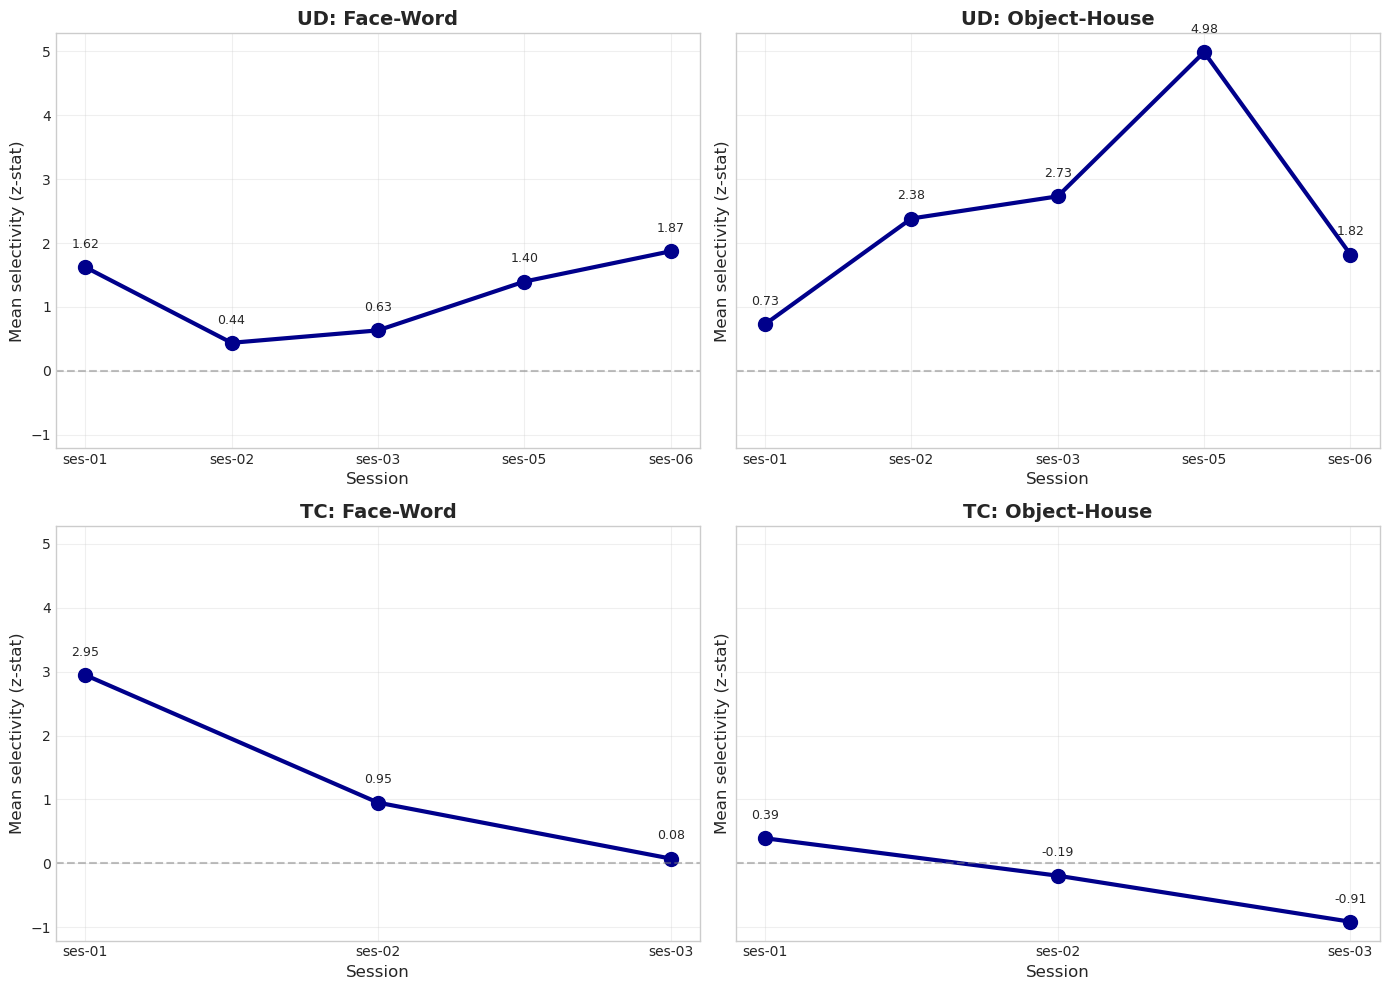


Extraction and visualization complete!


In [35]:
# Plot longitudinal progression

#fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for subj_idx, subject_id in enumerate(['sub-004', 'sub-021']):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for roi_idx, roi_type in enumerate(['face_word', 'object_house']):
        ax = axes[subj_idx, roi_idx]
        
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        # Get values in order
        sessions_available = [s for s in sessions if s in means_dict]
        means = [means_dict[s] for s in sessions_available]
        
        # Plot
        ax.plot(range(len(means)), means, 'o-', linewidth=3, markersize=10, color='darkblue')
        ax.set_xticks(range(len(sessions_available)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions_available])
        ax.set_ylabel('Mean selectivity (z-stat)', fontsize=12)
        ax.set_xlabel('Session', fontsize=12)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # Title
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        ax.set_title(f'{code}: {roi_label}', fontsize=14, fontweight='bold')
        
        # Annotate values
        for i, (ses, val) in enumerate(zip(sessions_available, means)):
            ax.text(i, val + 0.3, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'dual_cluster_longitudinal.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Extraction and visualization complete!")

In [36]:
# 1. Statistical comparison between sessions (matching Liu's analysis)

from scipy import stats

print("="*80)
print("STATISTICAL ANALYSIS: Pairwise Session Comparisons")
print("="*80)

def compare_sessions_stats(subject_id, roi_type='face_word'):
    """T-tests between all session pairs"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    # Load all sessions with correct registered files
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
    
    sessions = sorted(session_data.keys())
    
    print(f"\n{SUBJECTS[subject_id]['code']} - {roi_type.upper()}")
    print("-"*60)
    
    # Pairwise comparisons
    results = []
    for i in range(len(sessions)):
        for j in range(i+1, len(sessions)):
            ses1, ses2 = sessions[i], sessions[j]
            
            t_stat, p_val = stats.ttest_ind(session_data[ses1], session_data[ses2])
            
            mean1 = session_data[ses1].mean()
            mean2 = session_data[ses2].mean()
            diff = mean2 - mean1
            
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            
            comparison = f"ses-{ses1} vs ses-{ses2}"
            if ses1 == sessions[0] and ses2 == sessions[1]:
                comparison += " [Liu: expect ns]"
            
            print(f"  {comparison}:")
            print(f"    Mean: {mean1:.2f} → {mean2:.2f} (Δ={diff:+.2f})")
            print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")
            
            results.append({
                'ses1': ses1, 'ses2': ses2,
                'mean1': mean1, 'mean2': mean2,
                't': t_stat, 'p': p_val, 'sig': sig
            })
    
    return results

# Run for both subjects
stats_results = {}
for subject_id in ['sub-004', 'sub-021']:
    stats_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        stats_results[subject_id][roi_type] = compare_sessions_stats(subject_id, roi_type)

STATISTICAL ANALYSIS: Pairwise Session Comparisons

UD - FACE_WORD
------------------------------------------------------------
  ses-01 vs ses-02 [Liu: expect ns]:
    Mean: 1.62 → 0.44 (Δ=-1.18)
    t=49.526, p=0.0000 ***
  ses-01 vs ses-03:
    Mean: 1.62 → 0.63 (Δ=-0.99)
    t=46.394, p=0.0000 ***
  ses-01 vs ses-05:
    Mean: 1.62 → 1.40 (Δ=-0.23)
    t=9.364, p=0.0000 ***
  ses-01 vs ses-06:
    Mean: 1.62 → 1.87 (Δ=+0.25)
    t=-11.379, p=0.0000 ***
  ses-02 vs ses-03:
    Mean: 0.44 → 0.63 (Δ=+0.19)
    t=-8.953, p=0.0000 ***
  ses-02 vs ses-05:
    Mean: 0.44 → 1.40 (Δ=+0.96)
    t=-38.967, p=0.0000 ***
  ses-02 vs ses-06:
    Mean: 0.44 → 1.87 (Δ=+1.43)
    t=-64.898, p=0.0000 ***
  ses-03 vs ses-05:
    Mean: 0.63 → 1.40 (Δ=+0.76)
    t=-34.574, p=0.0000 ***
  ses-03 vs ses-06:
    Mean: 0.63 → 1.87 (Δ=+1.24)
    t=-64.311, p=0.0000 ***
  ses-05 vs ses-06:
    Mean: 1.40 → 1.87 (Δ=+0.47)
    t=-21.144, p=0.0000 ***

UD - OBJECT_HOUSE
-----------------------------------------


Creating Figure 5 visualizations...
Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_liu_style.png


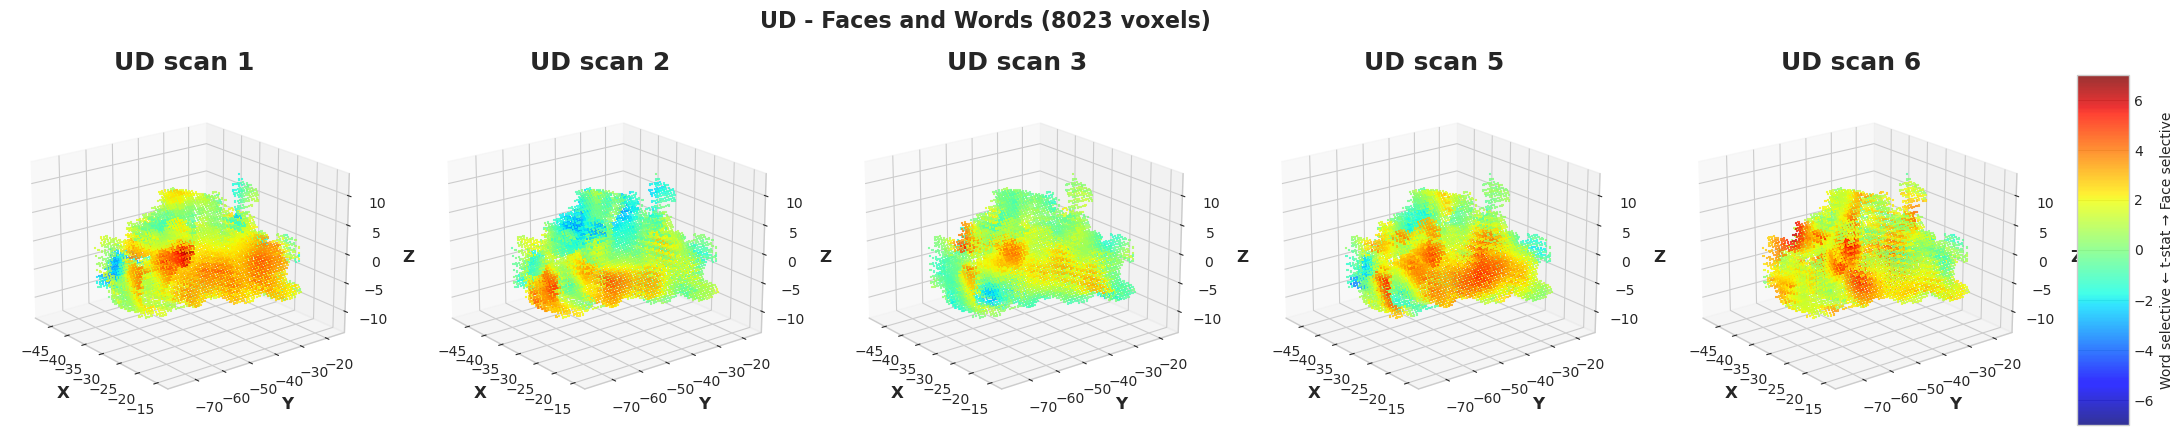

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_liu_style.png


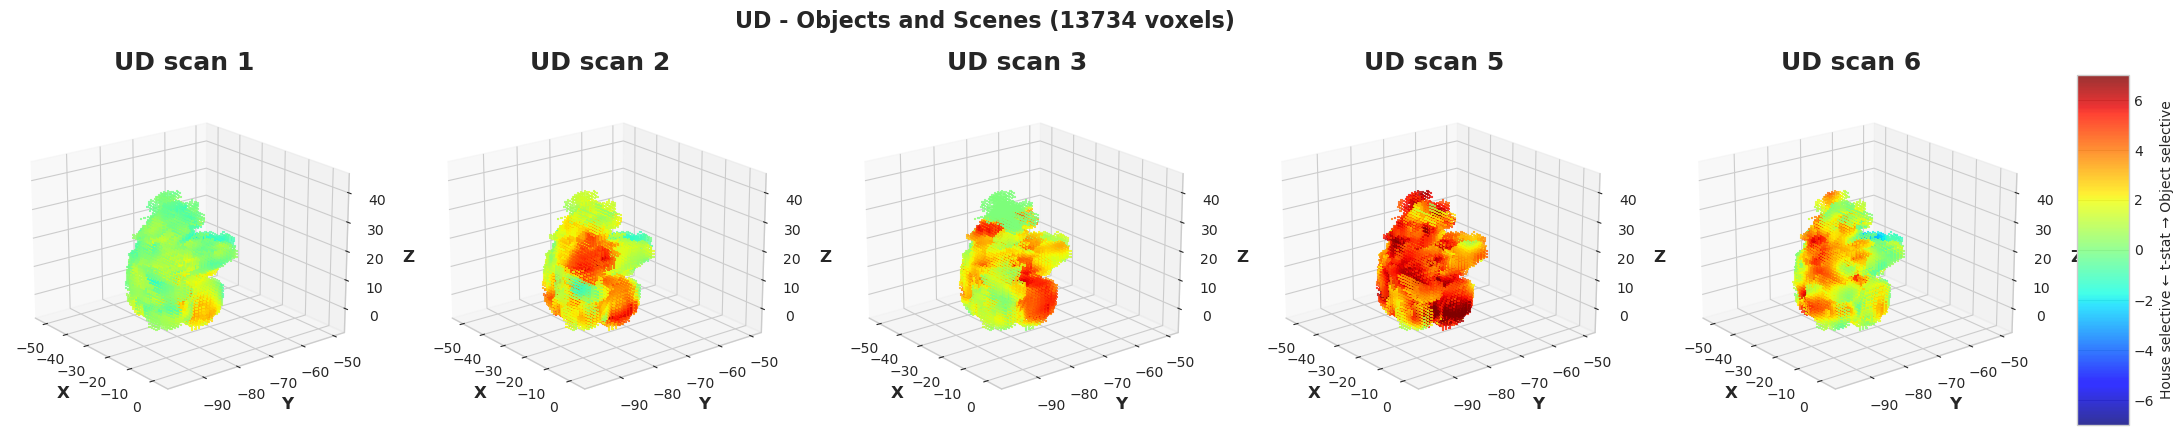

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_liu_style.png


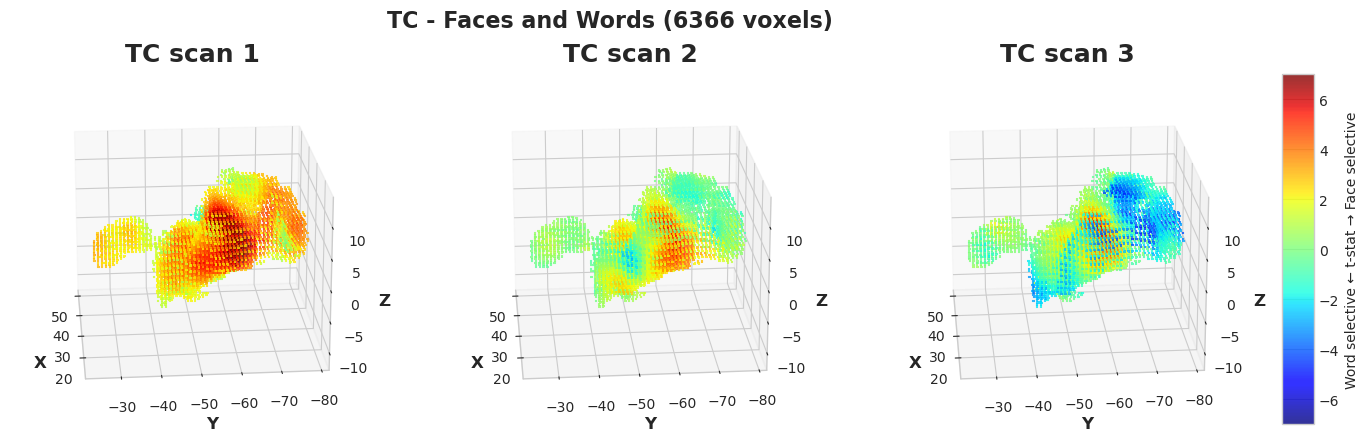

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_liu_style.png


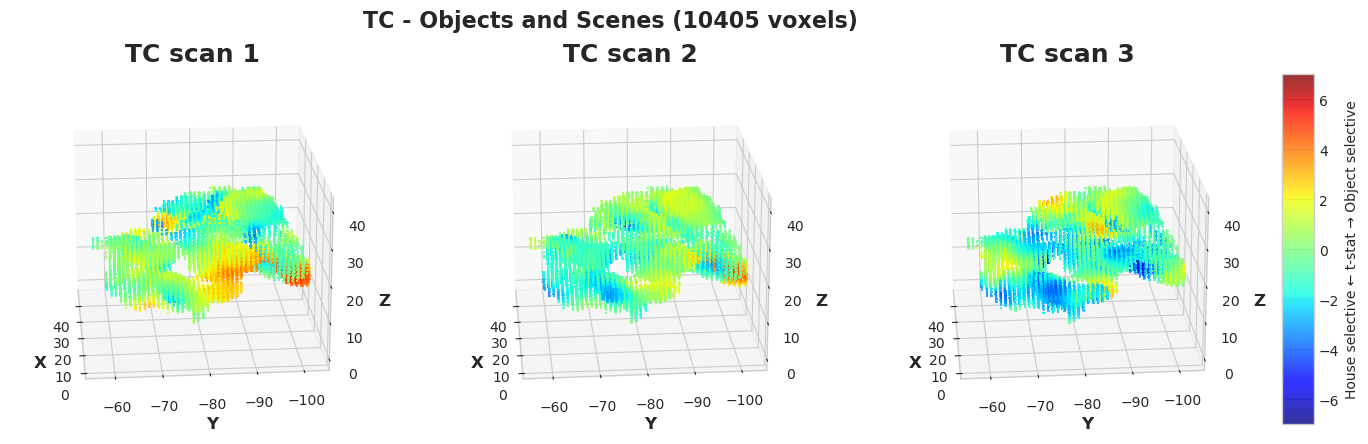

In [31]:
# 2. Figure 5 style visualization with dual-cluster ROIs

def create_figure5_liu_style(subject_id, roi_type='face_word', save_path=None):
    """Recreate Liu's Figure 5 visualization"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    info = SUBJECTS[subject_id]
    
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in info['sessions']:
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            t_stats = zstat_data[voxel_indices]
            session_data[session] = t_stats
    
    sessions = sorted(session_data.keys())
    n_sessions = len(sessions)
    
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        t_stats = session_data[ses]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} scan {int(ses)}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'Faces and Words' if roi_type == 'face_word' else 'Objects and Scenes'
    n_voxels = len(world_coords)
    fig.suptitle(f'{info["code"]} - {roi_label} ({n_voxels} voxels)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


# Create Liu-style Figure 5
print("\nCreating Figure 5 visualizations...")
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_liu_style.png'
        create_figure5_liu_style(subject_id, roi_type, save_path)

In [32]:
# 3. Summary table comparing to Liu's findings

print("\n" + "="*80)
print("SUMMARY: COMPARISON TO LIU ET AL. FINDINGS")
print("="*80)

print("\nLIU'S FINDING:")
print("  'Significant differences in t(face-word) between any two sessions'")
print("  'EXCEPT for comparisons between scans 1 and 2'")
print()

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} - Face-Word:")
    print("-"*40)
    
    # Get ses-1 vs ses-2 result
    fw_results = stats_results[subject_id]['face_word']
    sessions = sorted(SUBJECTS[subject_id]['sessions'])
    
    ses1_vs_2 = [r for r in fw_results if r['ses1'] == sessions[0] and r['ses2'] == sessions[1]]
    
    if ses1_vs_2:
        r = ses1_vs_2[0]
        print(f"  Scan 1 vs Scan 2: p={r['p']:.4f} {r['sig']}")
        if r['sig'] == 'ns':
            print(f"    ✓ MATCHES Liu (non-significant)")
        else:
            print(f"    ✗ Differs from Liu (significant)")
    
    # Check other comparisons
    other_comparisons = [r for r in fw_results if not (r['ses1'] == sessions[0] and r['ses2'] == sessions[1])]
    n_sig = sum(1 for r in other_comparisons if r['sig'] != 'ns')
    
    print(f"  Other comparisons: {n_sig}/{len(other_comparisons)} significant")
    if n_sig == len(other_comparisons):
        print(f"    ✓ MATCHES Liu (all other comparisons significant)")
    else:
        print(f"    ~ Partial match ({n_sig}/{len(other_comparisons)} significant)")
    
    # Show trajectory
    means_dict = dual_extractions[subject_id]['face_word']['means']
    trajectory = [means_dict[s] for s in sessions if s in means_dict]
    print(f"  Trajectory: {' → '.join([f'{v:.2f}' for v in trajectory])}")

print("\n" + "="*80)


SUMMARY: COMPARISON TO LIU ET AL. FINDINGS

LIU'S FINDING:
  'Significant differences in t(face-word) between any two sessions'
  'EXCEPT for comparisons between scans 1 and 2'


UD - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 9/9 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 1.62 → 0.44 → 0.63 → 1.40 → 1.87

TC - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 2/2 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 2.95 → 0.95 → 0.08



In [49]:
# CELL: Create dual-cluster ROIs (missing from your notebook)

def create_dual_cluster_roi(subject_id, roi_type='face_word', target_percentile=75):
    """
    Create ROI from TWO separate clusters (face AND word, or object AND house)
    Using corrected copes (10,12,3,11)
    """
    hemi = SUBJECTS[subject_id]['hemi']
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{'='*60}")
    print(f"{code} - {roi_type.upper()} (Dual-Cluster)")
    print(f"{'='*60}")
    
    # Select anatomical constraint and copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 10, 'face'  # face>scramble
        cope2_num, cope2_name = 12, 'word'  # word>scramble
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 3, 'object'  # object>scramble
        cope2_num, cope2_name = 11, 'house'  # house>scramble
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load individual condition z-stats
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_data = nib.load(cope1_file).get_fdata()
    cope2_data = nib.load(cope2_file).get_fdata()
    
    # Cluster 1
    print(f"\nFinding {cope1_name} cluster...")
    roi1_values = cope1_data[anat_mask]
    threshold1 = np.percentile(roi1_values, target_percentile)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
    
    # Cluster 2
    print(f"Finding {cope2_name} cluster...")
    roi2_values = cope2_data[anat_mask]
    threshold2 = np.percentile(roi2_values, target_percentile)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
    
    # Union
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined: {n_total} voxels ({cope1_name}={n_vox1}, {cope2_name}={n_vox2}, overlap={n_overlap})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_corrected.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    
    return {
        'mask_file': output_file,
        'n_total': n_total,
        'n_cluster1': n_vox1,
        'n_cluster2': n_vox2,
        'n_overlap': n_overlap,
        'cluster1_mask': cluster1_mask,
        'cluster2_mask': cluster2_mask
    }

# Create dual-cluster ROIs
roi_results_dual = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_dual[subject_id] = {}
    roi_results_dual[subject_id]['face_word'] = create_dual_cluster_roi(subject_id, 'face_word')
    roi_results_dual[subject_id]['object_house'] = create_dual_cluster_roi(subject_id, 'object_house')

print("\n✓ Dual-cluster ROIs created")


UD - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4284 voxels (z>0.29)
Finding word cluster...
  word: 4326 voxels (z>0.00)

Combined: 6146 voxels (face=4284, word=4326, overlap=2464)

UD - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 7839 voxels (z>0.77)
Finding house cluster...
  house: 6861 voxels (z>-0.10)

Combined: 10625 voxels (object=7839, house=6861, overlap=4075)

TC - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4488 voxels (z>5.69)
Finding word cluster...
  word: 3351 voxels (z>0.97)

Combined: 5794 voxels (face=4488, word=3351, overlap=2045)

TC - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 6906 voxels (z>4.86)
Finding house cluster...
  house: 5400 voxels (z>1.41)

Combined: 9866 voxels (object=6906, house=5400, overlap=2440)

✓ Dual-cluster ROIs created


In [50]:
# Comprehensive results summary

print("="*80)
print("DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY")
print("="*80)

print("\n" + "="*80)
print("1. ROI COMPOSITION (ses-01)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} ({subject_id}):")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        result = roi_results_dual[subject_id][roi_type]
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        
        print(f"\n  {roi_label} ROI:")
        print(f"    Total voxels: {result['n_total']}")
        
        if roi_type == 'face_word':
            print(f"    Face-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    Word-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        else:
            print(f"    Object-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    House-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        print(f"    Overlap: {result['n_overlap']} ({100*result['n_overlap']/result['n_total']:.1f}%)")

print("\n" + "="*80)
print("2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        print(f"\n  {roi_label}:")
        for ses in SUBJECTS[subject_id]['sessions']:
            if ses in means_dict:
                print(f"    ses-{ses}: {means_dict[ses]:+.2f}")

print("\n" + "="*80)
print("3. SESSION-TO-SESSION CHANGES")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
        
        print(f"\n  {roi_label}:")
        for i in range(len(sessions)-1):
            ses1, ses2 = sessions[i], sessions[i+1]
            change = means_dict[ses2] - means_dict[ses1]
            print(f"    ses-{ses1} → ses-{ses2}: {change:+.2f}")
        
        # Overall change
        if len(sessions) >= 2:
            total_change = means_dict[sessions[-1]] - means_dict[sessions[0]]
            print(f"    Overall (ses-{sessions[0]} → ses-{sessions[-1]}): {total_change:+.2f}")

print("\n" + "="*80)
print("4. COMPARISON TO LIU ET AL. EXPECTATIONS")
print("="*80)

print("\nLiu et al. findings:")
print("  UD: Progressive INCREASE in face-word selectivity")
print("  TC: Significant changes over time")
print("  OT: No significant change (control)")

print("\nYour findings:")
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    means_dict = dual_extractions[subject_id]['face_word']['means']
    sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
    
    if len(sessions) >= 2:
        baseline = means_dict[sessions[0]]
        final = means_dict[sessions[-1]]
        change = final - baseline
        
        pattern = "INCREASE" if change > 0 else "DECREASE"
        print(f"  {code}: {pattern} ({baseline:.2f} → {final:.2f}, Δ={change:+.2f})")

print("\n" + "="*80)
print("5. KEY OBSERVATIONS")
print("="*80)

# Analyze patterns
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    fw_means = dual_extractions[subject_id]['face_word']['means']
    oh_means = dual_extractions[subject_id]['object_house']['means']
    
    fw_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in fw_means]
    oh_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in oh_means]
    
    print(f"\n{code}:")
    
    # Face-word trajectory
    if len(fw_sessions) >= 2:
        fw_values = [fw_means[s] for s in fw_sessions]
        fw_trend = "increasing" if fw_values[-1] > fw_values[0] else "decreasing"
        fw_stable = all(abs(fw_values[i+1] - fw_values[i]) < 0.5 for i in range(len(fw_values)-1))
        
        print(f"  Face-Word: {fw_trend} trajectory")
        if fw_stable:
            print(f"    Relatively stable (max change < 0.5)")
    
    # Object-house trajectory  
    if len(oh_sessions) >= 2:
        oh_values = [oh_means[s] for s in oh_sessions]
        oh_trend = "increasing" if oh_values[-1] > oh_values[0] else "decreasing"
        oh_stable = all(abs(oh_values[i+1] - oh_values[i]) < 0.5 for i in range(len(oh_values)-1))
        
        print(f"  Object-House: {oh_trend} trajectory")
        if oh_stable:
            print(f"    Relatively stable (max change < 0.5)")

print("\n" + "="*80)
print("END OF SUMMARY")
print("="*80)

DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY

1. ROI COMPOSITION (ses-01)

UD (sub-004):
----------------------------------------

  Face-Word ROI:
    Total voxels: 6146
    Face-only: 1820 (29.6%)
    Word-only: 1862 (30.3%)
    Overlap: 2464 (40.1%)

  Object-House ROI:
    Total voxels: 10625
    Object-only: 3764 (35.4%)
    House-only: 2786 (26.2%)
    Overlap: 4075 (38.4%)

TC (sub-021):
----------------------------------------

  Face-Word ROI:
    Total voxels: 5794
    Face-only: 2443 (42.2%)
    Word-only: 1306 (22.5%)
    Overlap: 2045 (35.3%)

  Object-House ROI:
    Total voxels: 9866
    Object-only: 4466 (45.3%)
    House-only: 2960 (30.0%)
    Overlap: 2440 (24.7%)

2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)

UD:
----------------------------------------

  Face-Word:
    ses-01: +1.62
    ses-02: +0.44
    ses-03: +0.63
    ses-05: +1.40
    ses-06: +1.87

  Object-House:
    ses-01: +0.73
    ses-02: +2.38
    ses-03: +2.73
    ses-05: +4.98
    ses-06

In [38]:
# McNemar with FUNCTIONAL dual-cluster ROIs
import pandas as pd
from scipy.stats import chi2

def run_mcnemar_functional(subject_id, roi_type):
    """Run McNemar on functional dual-cluster ROI"""
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load FUNCTIONAL ROI (dual-cluster)
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Extract values
    session_values = {}
    # Replace the file loading section with:
    for session in sessions:
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                    'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            session_values[session] = zstat_data[voxel_indices]
    
    
    results = []
    for i in range(len(sessions) - 1):
        ses1, ses2 = sessions[i], sessions[i+1]
        if ses1 not in session_values or ses2 not in session_values:
            continue
        
        vals1, vals2 = session_values[ses1], session_values[ses2]
        mean1, mean2 = vals1.mean(), vals2.mean()
        
        cat1_high = vals1 > (mean1 + 1.5)
        cat1_low = vals1 < (mean1 - 1.5)
        cat2_high = vals2 > (mean2 + 1.5)
        cat2_low = vals2 < (mean2 - 1.5)
        
        b = np.sum(cat1_high & cat2_low)
        c = np.sum(cat1_low & cat2_high)
        chi2_stat = (abs(b - c) - 1)**2 / (b + c) if (b + c) > 0 else 0
        p_val = 1 - chi2.cdf(chi2_stat, df=1)
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        results.append((f'ses-{ses1}→{ses2}', f'{chi2_stat:.3f}', f'{p_val:.4f} {sig}'))
    
    return results

# Liu's values (static)
liu_fw = {
    'sub-004': [
        ('ses-01→02', '-', '0.844 ns (t-test)'),
        ('ses-02→03', '8.10-21.06', '<0.004 **'),
        ('ses-03→05', '8.10-21.06', '<0.004 **'),
        ('ses-05→06', '3.273', '0.070 ns')
    ],
    'sub-021': [
        ('ses-01→02', '87.699', '<0.001 ***'),
        ('ses-02→03', '9.333', '0.002 **')
    ]
}

# Run on functional ROIs
your_fw = {sid: run_mcnemar_functional(sid, 'face_word') for sid in ['sub-004', 'sub-021']}
your_oh = {sid: run_mcnemar_functional(sid, 'object_house') for sid in ['sub-004', 'sub-021']}

# TABLE 1
print("\n" + "="*100)
print("TABLE 1: Face-Word Competition (Functional ROIs)")
print("="*100)

fw_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    liu_data = {r[0]: (r[1], r[2]) for r in liu_fw[subject_id]}
    your_data = {r[0]: (r[1], r[2]) for r in your_fw[subject_id]}
    
    all_comps = sorted(set(liu_data.keys()) | set(your_data.keys()))
    for comp in all_comps:
        liu_chi2, liu_p = liu_data.get(comp, ('-', '-'))
        your_chi2, your_p = your_data.get(comp, ('-', '-'))
        fw_data.append([code, comp, liu_chi2, liu_p, your_chi2, your_p])

df1 = pd.DataFrame(fw_data, columns=['Subject', 'Comparison', 'Liu χ²', 'Liu p', 'Your χ²', 'Your p'])
print(df1.to_string(index=False))

# TABLE 2
print("\n" + "="*100)
print("TABLE 2: Object-House Competition (Functional ROIs - Novel)")
print("="*100)

oh_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    for comp, chi2_str, p_str in your_oh[subject_id]:
        oh_data.append([code, comp, chi2_str, p_str])

df2 = pd.DataFrame(oh_data, columns=['Subject', 'Comparison', 'χ²', 'p-value'])
print(df2.to_string(index=False))


TABLE 1: Face-Word Competition (Functional ROIs)
Subject Comparison     Liu χ²             Liu p Your χ²     Your p
     UD  ses-01→02          - 0.844 ns (t-test)   6.881  0.0087 **
     UD  ses-02→03 8.10-21.06         <0.004 **  57.962 0.0000 ***
     UD  ses-03→05 8.10-21.06         <0.004 **   2.400  0.1213 ns
     UD  ses-05→06      3.273          0.070 ns   4.817   0.0282 *
     TC  ses-01→02     87.699        <0.001 ***   6.250   0.0124 *
     TC  ses-02→03      9.333          0.002 **   1.633  0.2012 ns

TABLE 2: Object-House Competition (Functional ROIs - Novel)
Subject Comparison     χ²    p-value
     UD  ses-01→02  0.000  1.0000 ns
     UD  ses-02→03 22.223 0.0000 ***
     UD  ses-03→05  0.040  0.8423 ns
     UD  ses-05→06  8.004  0.0047 **
     TC  ses-01→02 33.750 0.0000 ***
     TC  ses-02→03  3.904   0.0482 *


# Stope here

/tmp/ipykernel_3944036/3283939873.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


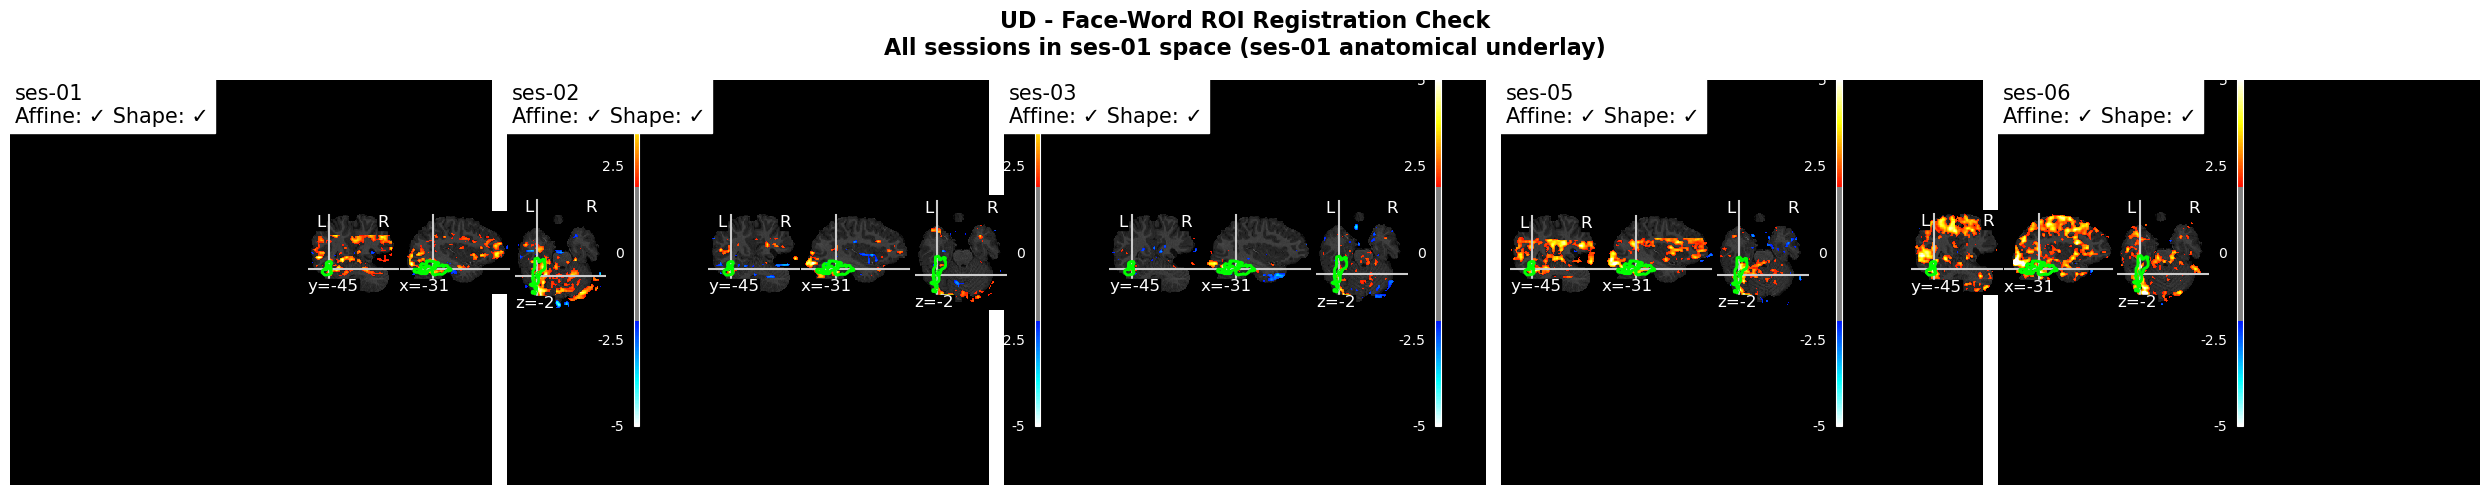


UD - Face-Word Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-05: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-06: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




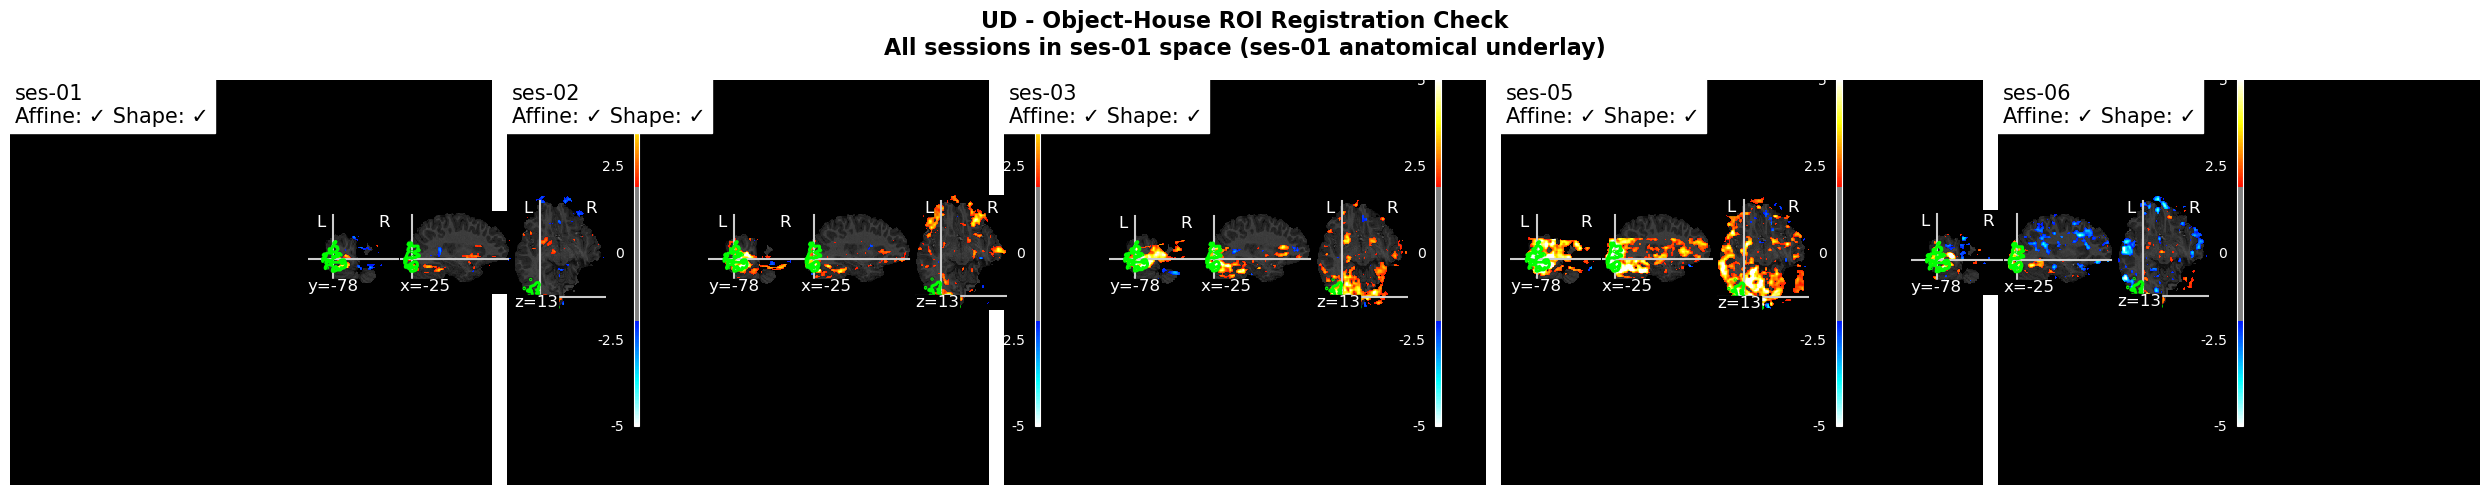


UD - Object-House Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-05: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-06: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




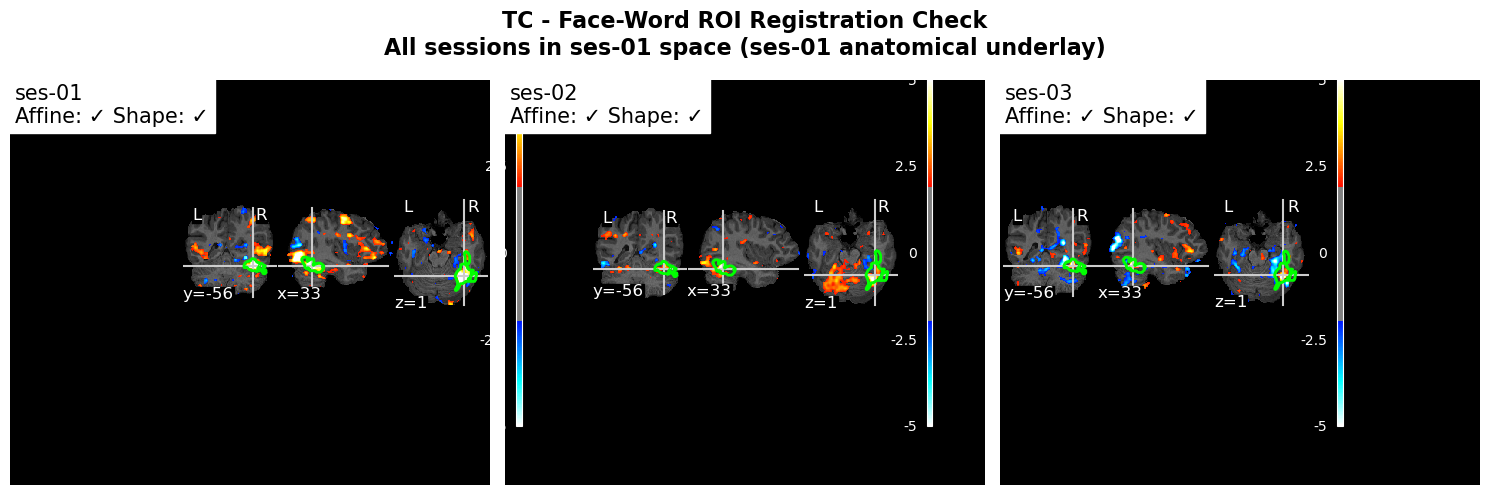


TC - Face-Word Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




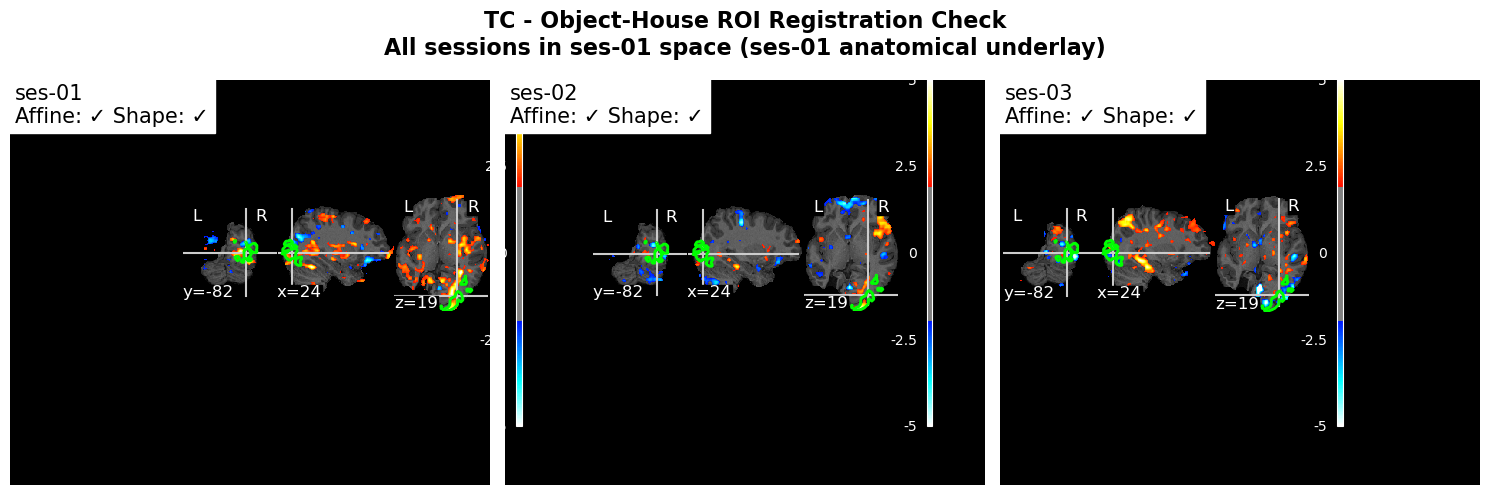


TC - Object-House Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




In [ ]:
# Visualization: Verify ses-01 registration with anatomical underlay
import matplotlib.pyplot as plt
from nilearn import plotting

def visualize_session_alignment(subject_id, roi_type='face_word', slice_coords=None):
    """
    Visualize that all sessions are properly registered to ses-01 space
    Shows ROI overlaid on each session's contrast map with anatomical underlay
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    code = SUBJECTS[subject_id]['code']
    
    # Load ses-01 anatomical as background
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    anat_img = nib.load(anat_file)
    
    # Load ROI (defined in ses-01 space)
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    
    # Get center of ROI for slicing if not provided
    if slice_coords is None:
        roi_coords = np.where(roi_img.get_fdata() > 0)
        center_vox = [int(np.mean(c)) for c in roi_coords]
        slice_coords = nib.affines.apply_affine(roi_img.affine, center_vox)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    # Create figure
    n_sessions = len(SUBJECTS[subject_id]['sessions'])
    fig, axes = plt.subplots(1, n_sessions, figsize=(5*n_sessions, 5))
    if n_sessions == 1:
        axes = [axes]
    
    fig.suptitle(f'{code} - {roi_name} ROI Registration Check\nAll sessions in ses-01 space (ses-01 anatomical underlay)', 
                 fontsize=16, fontweight='bold')
    
    for idx, session in enumerate(SUBJECTS[subject_id]['sessions']):
        # Load appropriate file
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
        
        if zstat_file.exists():
            # Check affine match
            zstat_img = nib.load(zstat_file)
            affine_match = np.allclose(roi_img.affine, zstat_img.affine)
            shape_match = roi_img.shape == zstat_img.shape
            
            # Plot with anatomical background
            display = plotting.plot_stat_map(
                zstat_img,
                bg_img=anat_img,  # Use ses-01 anatomical as background
                cut_coords=slice_coords,
                display_mode='ortho',
                threshold=1.96,
                title=f'ses-{session}\nAffine: {"✓" if affine_match else "✗"} Shape: {"✓" if shape_match else "✗"}',
                axes=axes[idx],
                colorbar=True,
                vmax=5,
                cmap='cold_hot'
            )
            
            # Overlay ROI contours
            display.add_contours(roi_img, levels=[0.5], colors='lime', linewidths=2)
            
        else:
            axes[idx].text(0.5, 0.5, f'ses-{session}\nFile not found', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{code} - {roi_name} Registration Summary:")
    print("="*60)
    for session in SUBJECTS[subject_id]['sessions']:
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
            file_type = "zstat1.nii.gz (native)"
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            file_type = "zstat1_ses01.nii.gz (registered)"
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            affine_match = np.allclose(roi_img.affine, zstat_img.affine)
            shape_match = roi_img.shape == zstat_img.shape
            print(f"  ses-{session}: {file_type}")
            print(f"    Affine match: {'✓' if affine_match else '✗'}")
            print(f"    Shape match: {'✓' if shape_match else '✗'}")
        else:
            print(f"  ses-{session}: ✗ File not found")

# Visualize all subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        visualize_session_alignment(subject_id, roi_type)
        print("\n")

METHODS SECTION:
ROI Definition
Category-selective regions of interest (ROIs) were defined in native space for each participant using anatomical and functional constraints. For the fusiform gyrus/occipitotemporal sulcus (FG/OTS) face-word ROI, we first identified the anatomical boundaries of the fusiform gyrus using FreeSurfer's automatic parcellation (aparc) of the structural T1-weighted image. Specifically, we extracted the lateral fusiform label and applied 2 iterations of morphological dilation (fslmaths -dilM) to ensure adequate cortical depth coverage, resulting in anatomical search spaces of approximately 24,000 voxels.
Within these anatomical constraints, we employed a dual-cluster functional localization approach to ensure balanced representation of both face and word selective voxels. For each category (faces and words), we identified the largest cluster of voxels exceeding the 75th percentile of activation values for that category's individual contrast (face>all baseline [cope 6] and word>all baseline [cope 9]) within the anatomical mask. The final ROI was defined as the union of these two clusters, yielding ROIs of 6,000-8,000 voxels for face-word comparisons. An analogous procedure was applied for object-house ROIs using lateral occipital cortex and parahippocampal place area anatomical boundaries, with object>all baseline (cope 8) and house>all baseline (cope 7) contrasts.
Longitudinal Analysis
To examine changes in category selectivity over time, we extracted face-word contrast values (face>word [cope 13]) from each participant's functionally-defined ROI across all available scanning sessions. All functional data were co-registered to the participant's first session structural scan to ensure accurate within-subject spatial correspondence across timepoints.
For statistical comparison between sessions, we performed independent samples t-tests on the voxel-wise contrast value distributions (following Liu et al., 2025), comparing all pairwise combinations of sessions. This voxel-distribution approach tests whether the population of selectivity values differs significantly between timepoints, accounting for the spatial heterogeneity of category representations within each ROI. Statistical significance was determined at p < 0.05 for each pairwise comparison.

# BELOW IS EXPERIMENTAL

In [39]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'  # FIXED: was cond2_name
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

In [40]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

def plot_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Plot 2x2 grid showing all condition×cluster combinations
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = "Normalized" if global_normalize else "Raw"
    
    results, cond1_name, cond2_name = extract_competition_matrix(
        subject_id, roi_type, global_normalize)
    
    sessions = SUBJECTS[subject_id]['sessions']
    session_nums = list(range(len(sessions)))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{code} - {roi_name} Competition Matrix ({norm_label})', 
                 fontsize=16, fontweight='bold')
    
    # Top left: Condition 1 in Cluster 1 (native territory)
    means = [results[cond1_name]['cluster1'][s] for s in sessions]
    axes[0, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red')
    axes[0, 0].set_title(f'{cond1_name.upper()} in {cond1_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[0, 0].set_ylabel('Mean Z-stat')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 0].set_xticks(session_nums)
    axes[0, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Top right: Condition 1 in Cluster 2 (invading)
    means = [results[cond1_name]['cluster2'][s] for s in sessions]
    axes[0, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red', alpha=0.6)
    axes[0, 1].set_title(f'{cond1_name.upper()} in {cond2_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].set_xticks(session_nums)
    axes[0, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom left: Condition 2 in Cluster 1 (invading)
    means = [results[cond2_name]['cluster1'][s] for s in sessions]
    axes[1, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue', alpha=0.6)
    axes[1, 0].set_title(f'{cond2_name.upper()} in {cond1_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[1, 0].set_xlabel('Session')
    axes[1, 0].set_ylabel('Mean Z-stat')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 0].set_xticks(session_nums)
    axes[1, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom right: Condition 2 in Cluster 2 (native territory)
    means = [results[cond2_name]['cluster2'][s] for s in sessions]
    axes[1, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue')
    axes[1, 1].set_title(f'{cond2_name.upper()} in {cond2_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[1, 1].set_xlabel('Session')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xticks(session_nums)
    axes[1, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    plt.tight_layout()
    plt.show()
    
    # Print full matrix
    print(f"\n{code} - {roi_name} Competition Matrix ({norm_label})")
    print("="*80)
    for session in sessions:
        print(f"\nses-{session}:")
        print(f"  {cond1_name.upper()} in {cond1_name} cluster: {results[cond1_name]['cluster1'][session]:.2f}")
        print(f"  {cond1_name.upper()} in {cond2_name} cluster: {results[cond1_name]['cluster2'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond1_name} cluster: {results[cond2_name]['cluster1'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond2_name} cluster: {results[cond2_name]['cluster2'][session]:.2f}")

# Run for both subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    plot_competition_matrix(subject_id, 'face_word', global_normalize=False)
    plot_competition_matrix(subject_id, 'object_house', global_normalize=False)

NameError: name 'roi_results_dual' is not defined


UD:
  face: 4284 vox, slope=+0.339, p=0.017
  word: 4326 vox, slope=-0.124, p=0.405
  house: 6861 vox, slope=+0.307, p=0.185
  object: 7839 vox, slope=+0.531, p=0.024

TC:
  face: 4488 vox, slope=-0.465, p=0.868
  word: 3351 vox, slope=+1.146, p=0.181
  house: 5400 vox, slope=+0.667, p=0.188
  object: 6906 vox, slope=-0.142, p=0.893


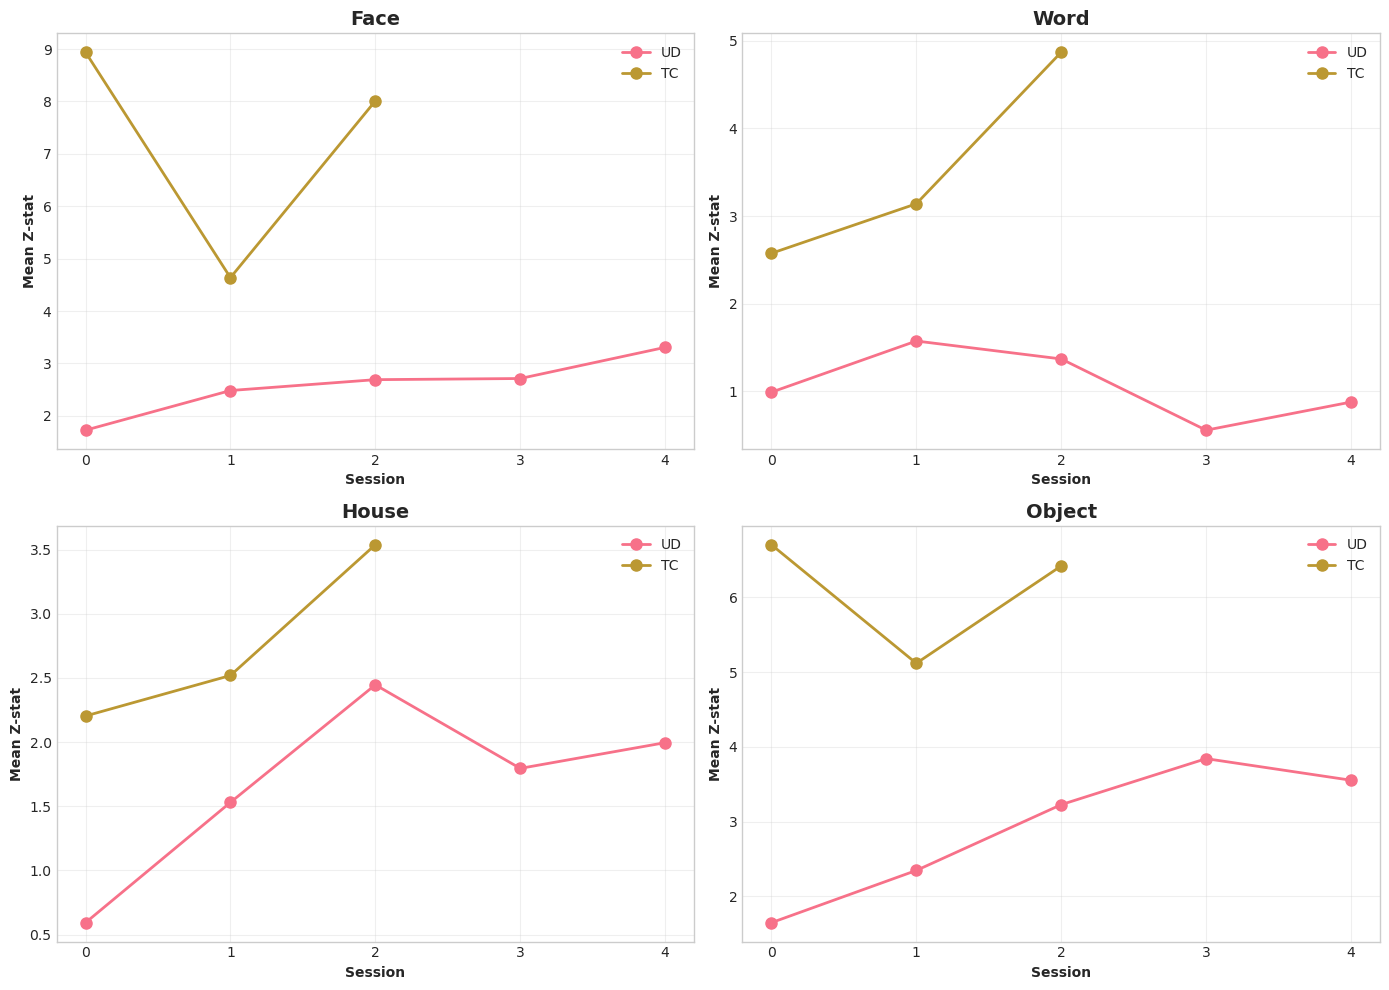


✓ Longitudinal activation tracking complete!


In [41]:
# CELL: Longitudinal activation tracking in single-category ROIs

from scipy import ndimage
from scipy.stats import linregress

def create_single_category_roi(subject_id, category, percentile=75):
    """Create ROI for single category (face, word, house, or object)"""
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    
    # Map category to cope and anatomical mask
    if category in ['face', 'word']:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope_num = 10 if category == 'face' else 12
    else:  # house or object
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope_num = 11 if category == 'house' else 3
    
    # Load data
    anat_mask = nib.load(anat_file).get_fdata() > 0
    cope_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope_img = nib.load(cope_file)
    cope_data = cope_img.get_fdata()
    
    # Threshold and get largest cluster
    thresh = np.percentile(cope_data[anat_mask], percentile)
    roi_mask = (cope_data > thresh) & anat_mask
    labeled, n_clusters = ndimage.label(roi_mask)
    
    if n_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
        largest = (labeled == (np.argmax(cluster_sizes) + 1))
    else:
        largest = roi_mask
    
    return largest, cope_img.affine

# Extract activation across sessions
results = {}
categories = ['face', 'word', 'house', 'object']
cope_map = {'face': 10, 'word': 12, 'house': 11, 'object': 3}

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    results[code] = {}
    
    print(f"\n{code}:")
    for category in categories:
        roi_mask, affine = create_single_category_roi(subject_id, category)
        voxel_idx = np.where(roi_mask)
        n_voxels = np.sum(roi_mask)
        
        activations = []
        cope_num = cope_map[category]
        
        for session in SUBJECTS[subject_id]['sessions']:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            data = nib.load(file).get_fdata()
            mean_activation = data[voxel_idx].mean()
            activations.append(mean_activation)
        
        results[code][category] = {
            'activations': activations,
            'n_voxels': n_voxels,
            'sessions': SUBJECTS[subject_id]['sessions']
        }
        
        # Linear trend
        x = np.arange(len(activations))
        slope, _, _, p, _ = linregress(x, activations)
        
        print(f"  {category}: {n_voxels} vox, slope={slope:+.3f}, p={p:.3f}")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, category in enumerate(categories):
    ax = axes[idx]
    
    for code in ['UD', 'TC']:
        data = results[code][category]
        sessions = data['sessions']
        x = np.arange(len(sessions))
        
        ax.plot(x, data['activations'], 'o-', label=code, markersize=8, linewidth=2)
    
    ax.set_title(f"{category.capitalize()}", fontweight='bold', fontsize=14)
    ax.set_xlabel('Session', fontweight='bold')
    ax.set_ylabel('Mean Z-stat', fontweight='bold')
    ax.set_xticks(range(max(len(results['UD'][category]['sessions']), 
                             len(results['TC'][category]['sessions']))))
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'category_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Longitudinal activation tracking complete!")

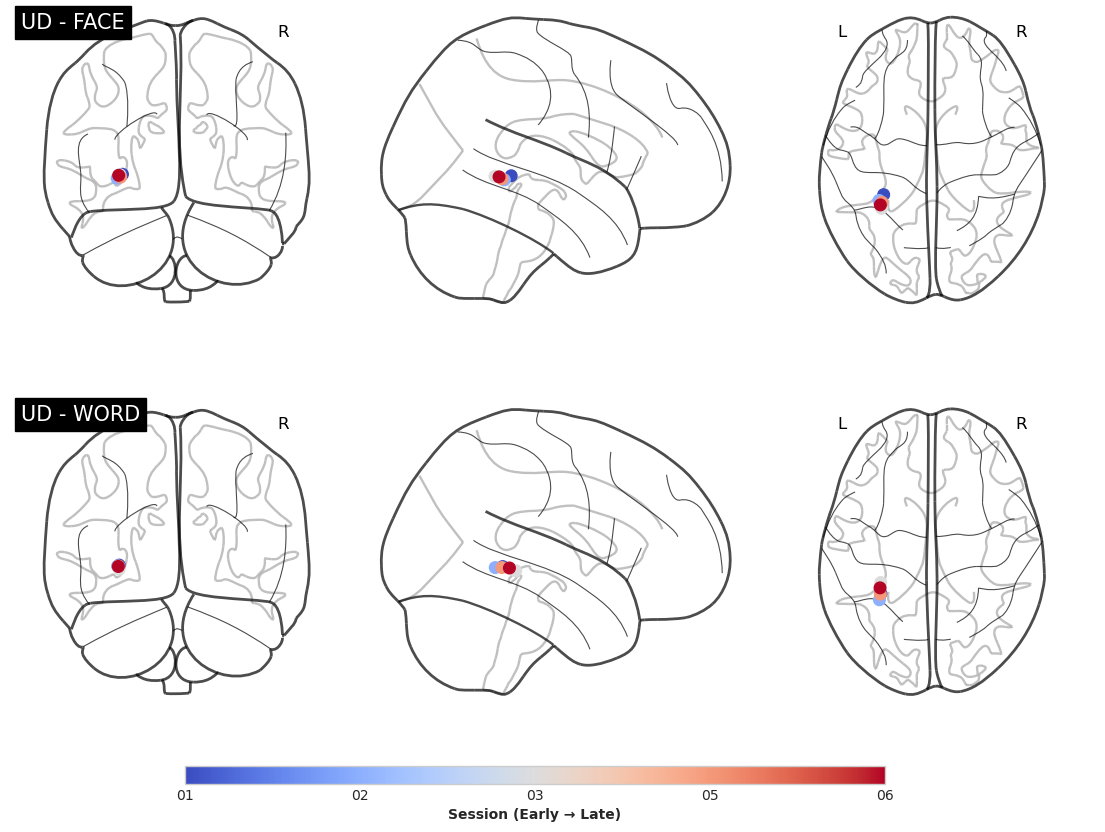

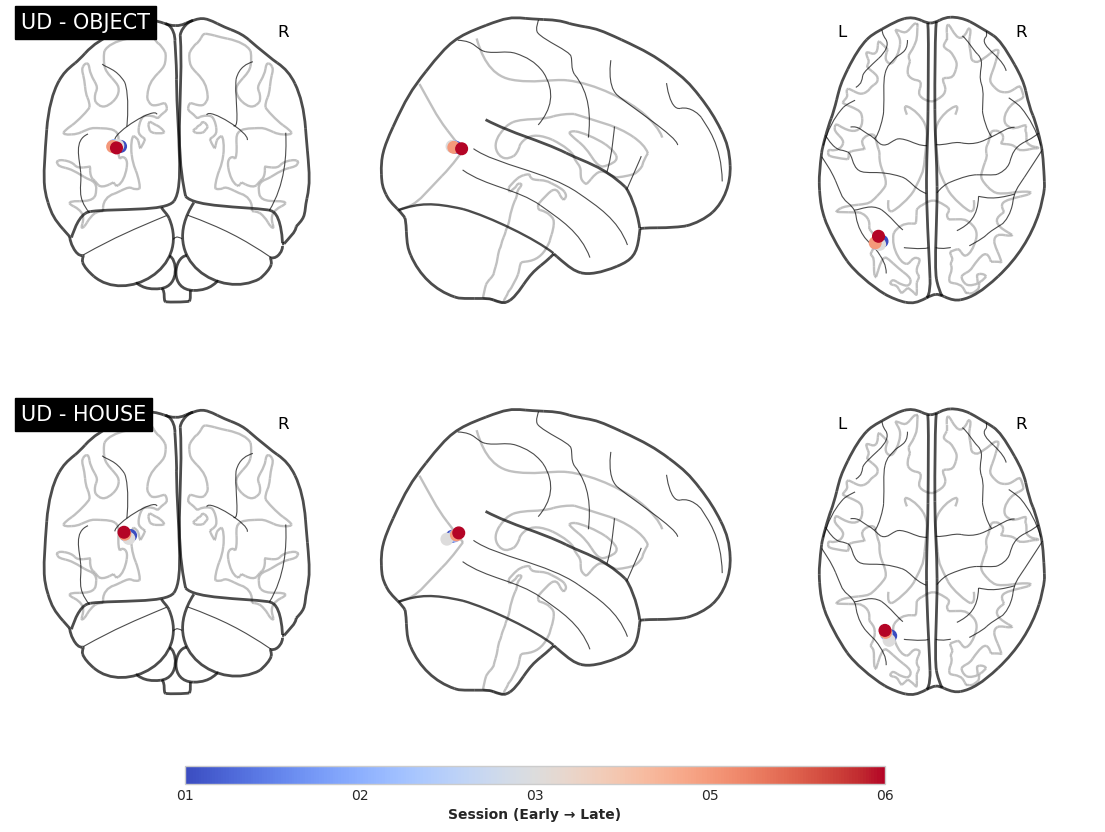

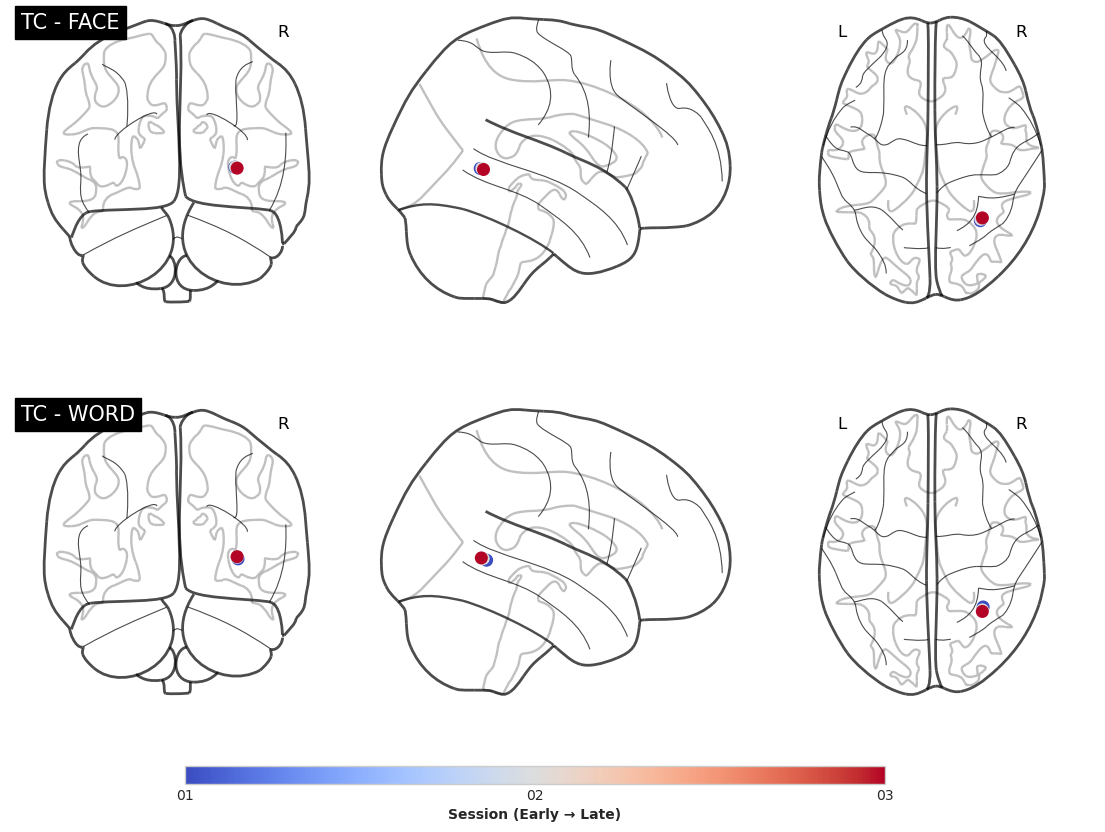

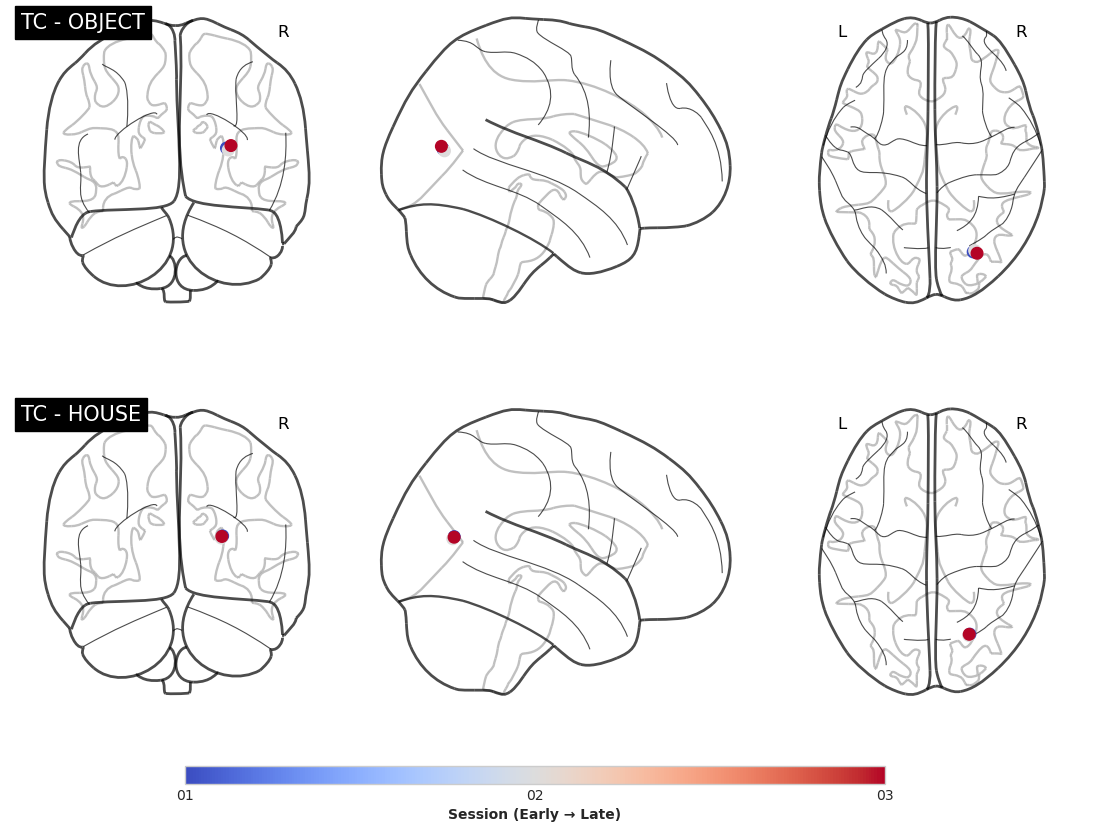

In [42]:
from scipy.ndimage import center_of_mass
from nilearn import plotting

OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def track_centroid_glass(subject_id, roi_type='face_word'):
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    code = SUBJECTS[subject_id]['code']
    
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        copes = {'face': 10, 'word': 12}
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        copes = {'object': 3, 'house': 11}
    
    anat_mask = nib.load(anat_file).get_fdata() > 0
    anat_affine = nib.load(anat_file).affine
    sessions = SUBJECTS[subject_id]['sessions']
    
    centroids = {cat: [] for cat in copes.keys()}
    
    for session in sessions:
        feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
        
        for cat, cope_num in copes.items():
            file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            data = nib.load(file).get_fdata()
            thresh = np.percentile(data[anat_mask], 75)
            cluster = (data > thresh) & anat_mask
            
            if cluster.sum() > 0:
                cent = nib.affines.apply_affine(anat_affine, center_of_mass(cluster))
                centroids[cat].append(cent)
    
    # Glass brain
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)
    
    for idx, (cat, coords) in enumerate(centroids.items()):
        if len(coords) == 0:
            continue
        coords = np.array(coords)
        adjacency = np.zeros((len(coords), len(coords)))
        colors = plt.cm.coolwarm(np.linspace(0, 1, len(coords)))
        
        ax = fig.add_subplot(gs[idx])
        plotting.plot_connectome(adjacency, coords, node_color=colors, 
                                node_size=70, axes=ax, colorbar=False,
                                title=f'{code} - {cat.upper()}')
    
    # Colorbar below
    cax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(1, len(sessions)))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Session (Early → Late)', fontweight='bold')
    cbar.set_ticks(range(1, len(sessions)+1))
    cbar.set_ticklabels(sessions)
    
    plt.savefig(OUTPUT_DIR / f'{code}_{roi_type}_glass.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run
for subj in ['sub-004', 'sub-021']:
    for roi in ['face_word', 'object_house']:
        track_centroid_glass(subj, roi)

In [ ]:
from scipy.ndimage import center_of_mass

def track_centroid_drift(subject_id, roi_type='face_word'):
    """Track centroid drift with CORRECTED copes (10,12,3,11)"""
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    code = SUBJECTS[subject_id]['code']
    
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 10, 'face'
        cope2_num, cope2_name = 12, 'word'
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 3, 'object'
        cope2_num, cope2_name = 11, 'house'
    
    anat_mask = nib.load(anat_file).get_fdata() > 0
    anat_affine = nib.load(anat_file).affine
    sessions = SUBJECTS[subject_id]['sessions']
    
    centroids = {
        cope1_name: {'voxel': {}, 'world': {}},
        cope2_name: {'voxel': {}, 'world': {}}
    }
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_type.upper()} Centroid Tracking")
    print(f"{'='*80}")
    
    for session in sessions:
        feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
        
        cope1_file = feat_dir / f'cope{cope1_num}.feat' / 'stats' / zstat_file
        cope2_file = feat_dir / f'cope{cope2_num}.feat' / 'stats' / zstat_file
        
        if not cope1_file.exists() or not cope2_file.exists():
            continue
            
        cope1_data = nib.load(cope1_file).get_fdata()
        cope2_data = nib.load(cope2_file).get_fdata()
        
        cope1_threshold = np.percentile(cope1_data[anat_mask], 75)
        cope2_threshold = np.percentile(cope2_data[anat_mask], 75)
        
        cope1_cluster = (cope1_data > cope1_threshold) & anat_mask
        cope2_cluster = (cope2_data > cope2_threshold) & anat_mask
        
        if cope1_cluster.sum() > 0:
            centroid1_vox = center_of_mass(cope1_cluster)
            centroid1_world = nib.affines.apply_affine(anat_affine, centroid1_vox)
            centroids[cope1_name]['voxel'][session] = centroid1_vox
            centroids[cope1_name]['world'][session] = centroid1_world
        
        if cope2_cluster.sum() > 0:
            centroid2_vox = center_of_mass(cope2_cluster)
            centroid2_world = nib.affines.apply_affine(anat_affine, centroid2_vox)
            centroids[cope2_name]['voxel'][session] = centroid2_vox
            centroids[cope2_name]['world'][session] = centroid2_world
    
    # Print displacements
    baseline = sessions[0]
    print(f"\nDisplacements from ses-{baseline} (mm):")
    print(f"{'Session':<10} {cope1_name.upper():>15} {cope2_name.upper():>15}")
    print("-"*80)
    
    for session in sessions:
        dist1 = dist2 = 0
        if session in centroids[cope1_name]['world'] and baseline in centroids[cope1_name]['world']:
            dist1 = np.linalg.norm(centroids[cope1_name]['world'][session] - 
                                   centroids[cope1_name]['world'][baseline])
        if session in centroids[cope2_name]['world'] and baseline in centroids[cope2_name]['world']:
            dist2 = np.linalg.norm(centroids[cope2_name]['world'][session] - 
                                   centroids[cope2_name]['world'][baseline])
        
        status1 = "STABLE" if dist1 < 5 else "DRIFT" if dist1 < 10 else "LARGE"
        status2 = "STABLE" if dist2 < 5 else "DRIFT" if dist2 < 10 else "LARGE"
        print(f"ses-{session:<6} {dist1:>10.2f} ({status1:^10}) {dist2:>10.2f} ({status2:^10})")
    
    return centroids

# Run
drift_results = {}
for subject_id in ['sub-004', 'sub-021']:
    drift_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        drift_results[subject_id][roi_type] = track_centroid_drift(subject_id, roi_type)


UD - FACE_WORD Centroid Tracking

Displacements from ses-01 (mm):
Session               FACE            WORD
--------------------------------------------------------------------------------
ses-01           0.00 (  STABLE  )       0.00 (  STABLE  )
ses-02           5.16 (  DRIFT   )       4.10 (  STABLE  )
ses-03           8.75 (  DRIFT   )       7.28 (  DRIFT   )
ses-05           5.22 (  DRIFT   )       0.72 (  STABLE  )
ses-06           6.82 (  DRIFT   )       3.71 (  STABLE  )

UD - OBJECT_HOUSE Centroid Tracking

Displacements from ses-01 (mm):
Session             OBJECT           HOUSE
--------------------------------------------------------------------------------
ses-01           0.00 (  STABLE  )       0.00 (  STABLE  )
ses-02           3.95 (  STABLE  )       3.02 (  STABLE  )
ses-03           2.47 (  STABLE  )       3.37 (  STABLE  )
ses-05           4.41 (  STABLE  )       3.97 (  STABLE  )
ses-06           3.98 (  STABLE  )       5.35 (  DRIFT   )

TC - FACE_WORD Centroid 

In [43]:
from scipy.ndimage import center_of_mass, label

def track_centroid_drift(subject_id, roi_type='face_word'):
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    code = SUBJECTS[subject_id]['code']
    
    if roi_type == 'face_word':
        # Use anatomical fusiform for both
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        configs = [
            {'cope_num': 10, 'name': 'face', 'anat': anat_file},
            {'cope_num': 12, 'name': 'word', 'anat': anat_file}
        ]
    else:
        # Create separate single-category ROIs for object and house
        lo_ppa_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        lo_ppa_mask = nib.load(lo_ppa_file).get_fdata() > 0
        affine = nib.load(lo_ppa_file).affine
        
        # Object ROI (from cope 3)
        obj_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                   'HighLevel.gfeat' / 'cope3.feat' / 'stats' / 'zstat1.nii.gz'
        obj_data = nib.load(obj_file).get_fdata()
        obj_thresh = np.percentile(obj_data[lo_ppa_mask], 75)
        obj_roi = (obj_data > obj_thresh) & lo_ppa_mask
        labeled_obj, _ = label(obj_roi)
        if labeled_obj.max() > 0:
            obj_roi = labeled_obj == (np.argmax(np.bincount(labeled_obj[labeled_obj > 0])[1:]) + 1)
        
        # House ROI (from cope 11)
        house_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / 'cope11.feat' / 'stats' / 'zstat1.nii.gz'
        house_data = nib.load(house_file).get_fdata()
        house_thresh = np.percentile(house_data[lo_ppa_mask], 75)
        house_roi = (house_data > house_thresh) & lo_ppa_mask
        labeled_house, _ = label(house_roi)
        if labeled_house.max() > 0:
            house_roi = labeled_house == (np.argmax(np.bincount(labeled_house[labeled_house > 0])[1:]) + 1)
        
        configs = [
            {'cope_num': 3, 'name': 'object', 'mask': obj_roi, 'affine': affine},
            {'cope_num': 11, 'name': 'house', 'mask': house_roi, 'affine': affine}
        ]
    
    sessions = SUBJECTS[subject_id]['sessions']
    centroids = {}
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_type.upper()}")
    print(f"{'='*80}")
    
    for config in configs:
        name = config['name']
        centroids[name] = {'voxel': {}, 'world': {}}
        
        # Get ROI mask
        if 'anat' in config:
            roi_mask = nib.load(config['anat']).get_fdata() > 0
            roi_affine = nib.load(config['anat']).affine
        else:
            roi_mask = config['mask']
            roi_affine = config['affine']
        
        print(f"\n{name.upper()} ROI: {np.sum(roi_mask)} voxels")
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            file = feat_dir / f'cope{config["cope_num"]}.feat' / 'stats' / zstat_file
            
            if not file.exists():
                continue
            
            data = nib.load(file).get_fdata()
            thresh = np.percentile(data[roi_mask], 75)
            cluster = (data > thresh) & roi_mask
            
            if cluster.sum() > 0:
                cent_vox = center_of_mass(cluster)
                cent_world = nib.affines.apply_affine(roi_affine, cent_vox)
                centroids[name]['voxel'][session] = cent_vox
                centroids[name]['world'][session] = cent_world
    
    # Print displacements
    baseline = sessions[0]
    print(f"\nDisplacements from ses-{baseline} (mm):")
    names = list(centroids.keys())
    print(f"{'Session':<10} {names[0].upper():>15} {names[1].upper():>15}")
    print("-"*80)
    
    for session in sessions:
        print(f"ses-{session:<6}", end='')
        for name in names:
            if session in centroids[name]['world'] and baseline in centroids[name]['world']:
                dist = np.linalg.norm(centroids[name]['world'][session] - centroids[name]['world'][baseline])
                status = "STABLE" if dist < 5 else "DRIFT" if dist < 10 else "LARGE"
                print(f" {dist:>10.2f} ({status:^10})", end='')
            else:
                print(f" {'---':>24}", end='')
        print()
    
    return centroids

# Run
drift_results = {}
for subject_id in ['sub-004', 'sub-021']:
    drift_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        drift_results[subject_id][roi_type] = track_centroid_drift(subject_id, roi_type)


UD - FACE_WORD

FACE ROI: 24305 voxels

WORD ROI: 24305 voxels

Displacements from ses-01 (mm):
Session               FACE            WORD
--------------------------------------------------------------------------------
ses-01           0.00 (  STABLE  )       0.00 (  STABLE  )
ses-02           5.16 (  DRIFT   )       4.10 (  STABLE  )
ses-03           8.75 (  DRIFT   )       7.28 (  DRIFT   )
ses-05           5.22 (  DRIFT   )       0.72 (  STABLE  )
ses-06           6.82 (  DRIFT   )       3.71 (  STABLE  )

UD - OBJECT_HOUSE

OBJECT ROI: 7839 voxels

HOUSE ROI: 6861 voxels

Displacements from ses-01 (mm):
Session             OBJECT           HOUSE
--------------------------------------------------------------------------------
ses-01           0.00 (  STABLE  )       0.00 (  STABLE  )
ses-02           2.12 (  STABLE  )       5.54 (  DRIFT   )
ses-03           3.58 (  STABLE  )       4.41 (  STABLE  )
ses-05           3.73 (  STABLE  )       4.23 (  STABLE  )
ses-06           7.02 (

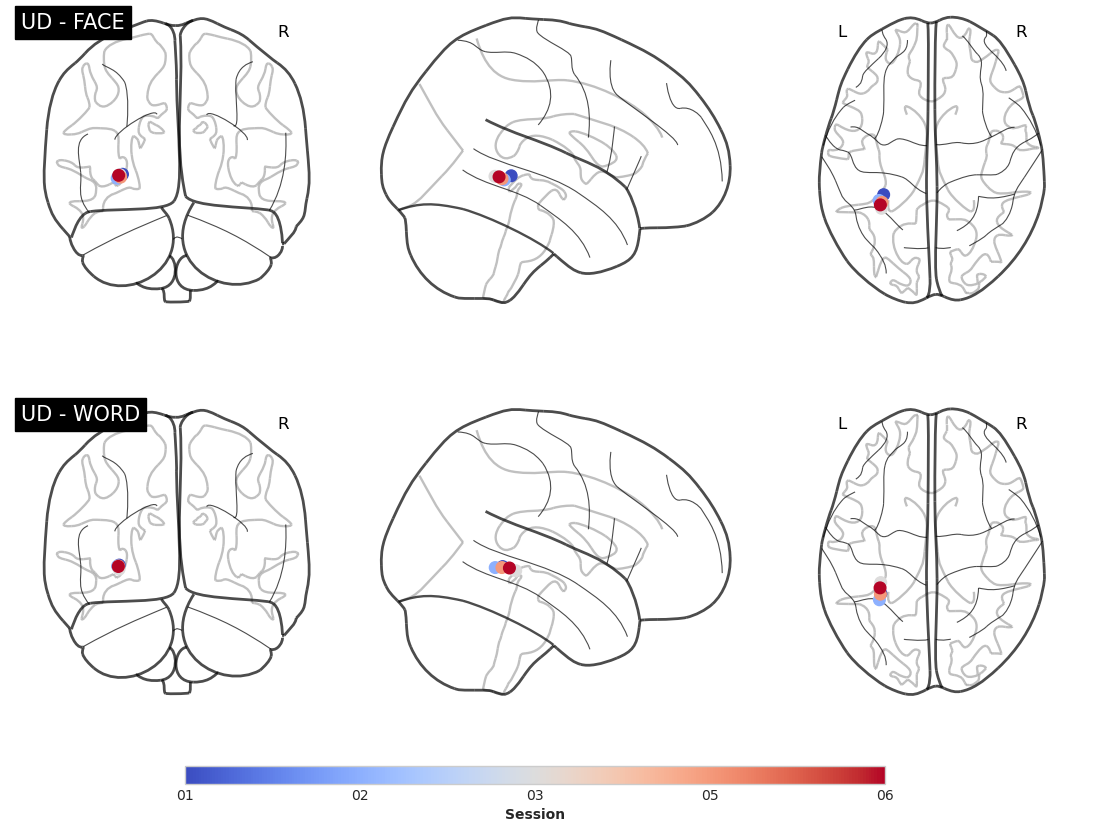

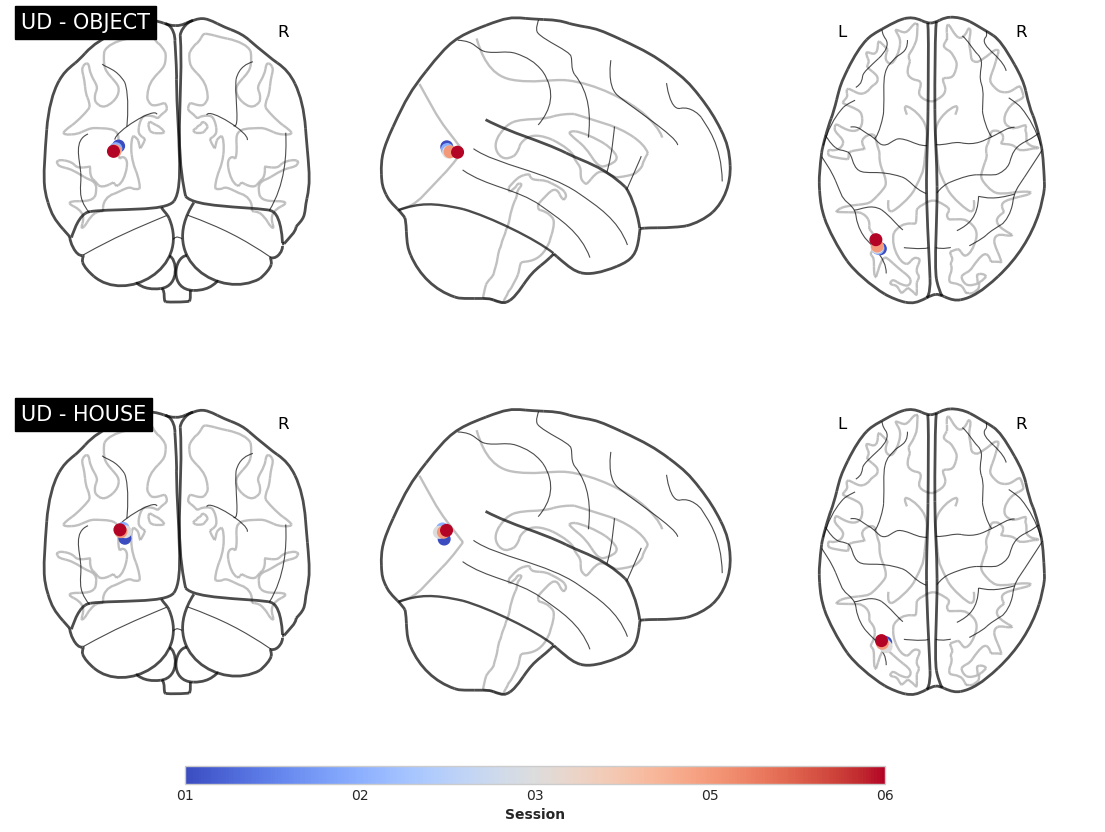

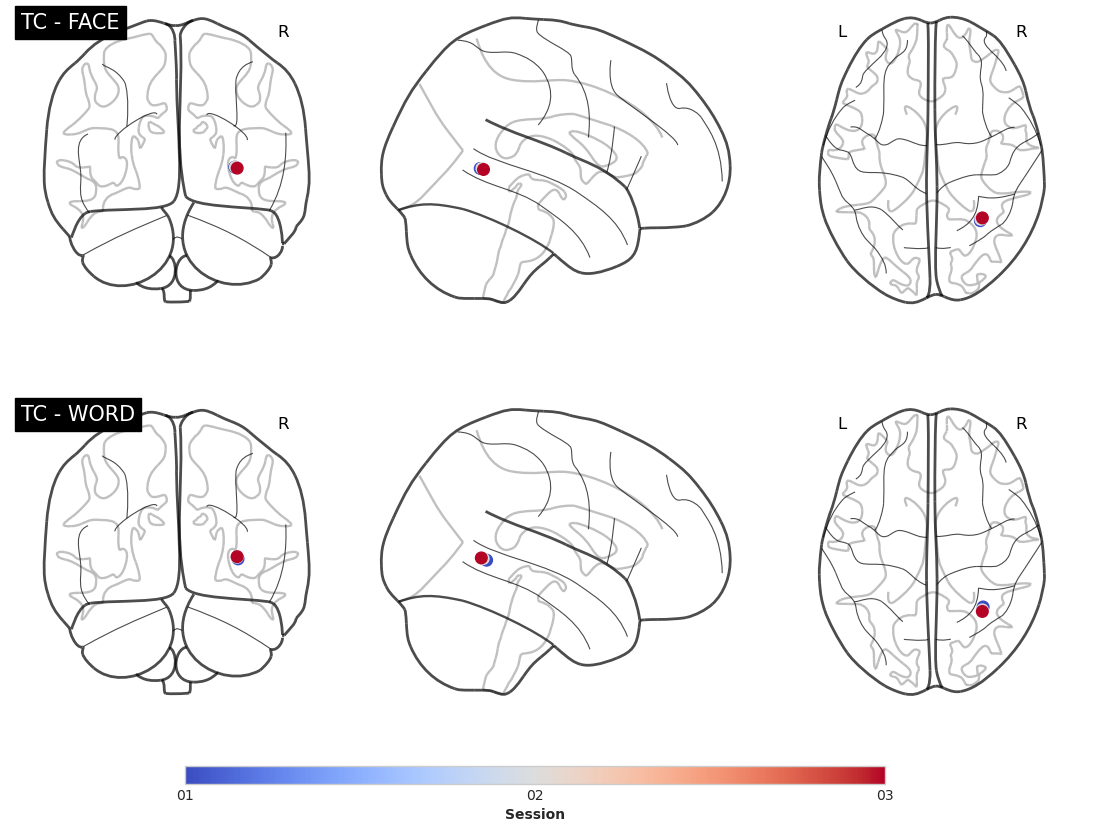

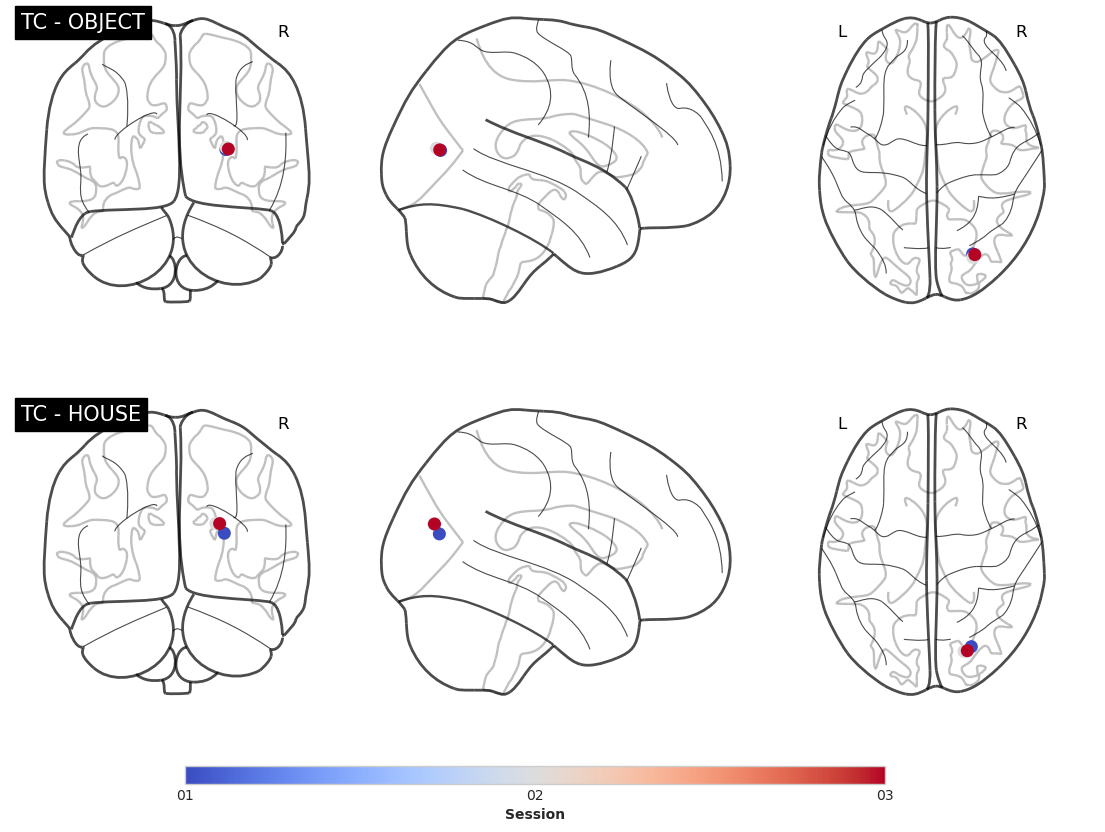

✓ Done


In [44]:
from nilearn import plotting

for subj in ['sub-004', 'sub-021']:
    code = SUBJECTS[subj]['code']
    sessions = SUBJECTS[subj]['sessions']
    
    for roi in ['face_word', 'object_house']:
        cats = list(drift_results[subj][roi].keys())
        
        fig = plt.figure(figsize=(14, 9))
        gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)
        
        for idx, cat in enumerate(cats):
            coords = []
            for s in sessions:
                if s in drift_results[subj][roi][cat]['world']:
                    coords.append(drift_results[subj][roi][cat]['world'][s])
            
            if len(coords) == 0:
                continue
                
            coords = np.array(coords)
            adjacency = np.zeros((len(coords), len(coords)))
            colors = plt.cm.coolwarm(np.linspace(0, 1, len(coords)))
            
            ax = fig.add_subplot(gs[idx])
            plotting.plot_connectome(adjacency, coords, node_color=colors, 
                                    node_size=70, axes=ax, colorbar=False,
                                    title=f'{code} - {cat.upper()}')
        
        # Colorbar
        cax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(1, len(sessions)))
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
        cbar.set_label('Session', fontweight='bold')
        cbar.set_ticks(range(1, len(sessions)+1))
        cbar.set_ticklabels(sessions)
        
        plt.savefig(OUTPUT_DIR / f'{code}_{roi}_centroids.png', dpi=300, bbox_inches='tight')
        plt.show()

print("✓ Done")

# NEW Golarai

In [29]:
# Golarai 2007 ROI Implementation
from scipy.ndimage import label, center_of_mass

def create_golarai_roi(subject_id, session, category):
    """
    Golarai-style functional ROI:
    - Contiguous cluster
    - Statistical threshold (p<0.001, z>3.09)
    - Within anatomical bounds
    - Largest cluster only
    """
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    
    # Anatomical constraint and cope mapping
    if category in ['face', 'word']:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope_map = {'face': 10, 'word': 12}
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope_map = {'object': 3, 'house': 11}
    
    # Load anatomical mask
    anat_img = nib.load(anat_file)
    anat_mask = anat_img.get_fdata() > 0
    
    # Load z-stat
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
    zstat_path = feat_dir / f'cope{cope_map[category]}.feat' / 'stats' / zstat_file
    
    if not zstat_path.exists():
        return None, None
    
    zstat_data = nib.load(zstat_path).get_fdata()
    
    # Threshold: p < 0.001 uncorrected = z > 3.09
    threshold = 3.09
    suprathreshold = (zstat_data > threshold) & anat_mask
    
    if suprathreshold.sum() == 0:
        return None, None
    
    # Get largest contiguous cluster
    labeled, n_clusters = label(suprathreshold)
    if n_clusters == 0:
        return None, None
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
    largest_cluster_idx = np.argmax(cluster_sizes) + 1
    roi_mask = (labeled == largest_cluster_idx)
    
    # Extract metrics
    roi_voxels = np.sum(roi_mask)
    peak_z = zstat_data[roi_mask].max()
    mean_z = zstat_data[roi_mask].mean()
    centroid = nib.affines.apply_affine(anat_img.affine, center_of_mass(roi_mask))
    
    metrics = {
        'n_voxels': roi_voxels,
        'peak_z': peak_z,
        'mean_z': mean_z,
        'centroid': centroid,
        'roi_mask': roi_mask
    }
    
    return roi_mask, metrics

def extract_golarai_rois_longitudinal(subject_id):
    """Extract Golarai ROIs across all sessions"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    categories = ['face', 'word', 'object', 'house']
    
    results = {cat: {} for cat in categories}
    
    print(f"\n{'='*80}")
    print(f"{code} - Golarai ROI Extraction")
    print(f"{'='*80}")
    
    for category in categories:
        print(f"\n{category.upper()}:")
        for session in sessions:
            roi_mask, metrics = create_golarai_roi(subject_id, session, category)
            
            if metrics is None:
                print(f"  ses-{session}: No ROI found")
                continue
            
            results[category][session] = metrics
            print(f"  ses-{session}: {metrics['n_voxels']:5d} voxels, "
                  f"peak_z={metrics['peak_z']:.2f}, mean_z={metrics['mean_z']:.2f}")
    
    return results

# Extract for both patients
golarai_results = {}
for subj in ['sub-004', 'sub-021']:
    golarai_results[subj] = extract_golarai_rois_longitudinal(subj)

print("\n✓ Golarai ROI extraction complete")


UD - Golarai ROI Extraction

FACE:
  ses-01:   427 voxels, peak_z=4.21, mean_z=3.46


  ses-02:  1902 voxels, peak_z=6.65, mean_z=4.12
  ses-03:  2865 voxels, peak_z=8.81, mean_z=4.51
  ses-05:  2690 voxels, peak_z=8.13, mean_z=4.58
  ses-06:  3658 voxels, peak_z=13.49, mean_z=5.24

WORD:
  ses-01:    17 voxels, peak_z=4.01, mean_z=3.45
  ses-02:   705 voxels, peak_z=5.75, mean_z=3.98
  ses-03:   450 voxels, peak_z=5.97, mean_z=3.79
  ses-05:   393 voxels, peak_z=5.86, mean_z=4.03
  ses-06:   450 voxels, peak_z=7.56, mean_z=4.23

OBJECT:
  ses-01:   221 voxels, peak_z=4.64, mean_z=3.48
  ses-02:  3611 voxels, peak_z=7.76, mean_z=4.11
  ses-03:  6731 voxels, peak_z=7.72, mean_z=4.52
  ses-05:  7924 voxels, peak_z=9.85, mean_z=4.85
  ses-06:  7022 voxels, peak_z=11.53, mean_z=5.70

HOUSE:
  ses-01:     2 voxels, peak_z=3.23, mean_z=3.19
  ses-02:  2296 voxels, peak_z=6.50, mean_z=3.99
  ses-03:  1636 voxels, peak_z=7.15, mean_z=4.21
  ses-05:  4261 voxels, peak_z=7.94, mean_z=4.37
  ses-06:  4828 voxels, peak_z=10.16, mean_z=4.87

TC - Golarai ROI Extraction

FACE:
  ses-

In [30]:
def create_golarai_spheres(subject_id, category, radii=[3, 6, 9]):
    """
    Create concentric spheres centered at ses-01 peak
    Then measure selectivity in these fixed locations across sessions
    """
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    code = SUBJECTS[subject_id]['code']
    
    # Anatomical constraint
    if category in ['face', 'word']:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope_num = 10 if category == 'face' else 12
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope_num = 3 if category == 'object' else 11
    
    anat_img = nib.load(anat_file)
    anat_mask = anat_img.get_fdata() > 0
    
    # Find peak in ses-01
    ses01_feat = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    zstat_file = ses01_feat / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    zstat = nib.load(zstat_file).get_fdata()
    
    # Peak within anatomical mask
    masked_zstat = zstat.copy()
    masked_zstat[~anat_mask] = -np.inf
    peak_idx = np.unravel_index(np.argmax(masked_zstat), zstat.shape)
    peak_world = nib.affines.apply_affine(anat_img.affine, peak_idx)
    
    print(f"\n{code} - {category.upper()}")
    print(f"  Peak (ses-01): {peak_world} mm, z={zstat[peak_idx]:.2f}")
    
    # Create spherical ROIs
    all_coords = np.array(np.where(anat_mask)).T
    all_coords_world = nib.affines.apply_affine(anat_img.affine, all_coords)
    distances = np.linalg.norm(all_coords_world - peak_world, axis=1)
    
    sphere_masks = {}
    for r in radii:
        mask_3d = np.zeros_like(anat_mask)
        within_sphere = all_coords[distances <= r]
        for coord in within_sphere:
            mask_3d[coord[0], coord[1], coord[2]] = 1
        sphere_masks[r] = mask_3d > 0
        print(f"  Sphere r={r}mm: {np.sum(sphere_masks[r])} voxels")
    
    # Track selectivity across sessions
    sessions = SUBJECTS[subject_id]['sessions']
    results = {r: {} for r in radii}
    
    for session in sessions:
        feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        zfile = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
        zpath = feat_dir / f'cope{cope_num}.feat' / 'stats' / zfile
        
        if not zpath.exists():
            continue
        
        zdata = nib.load(zpath).get_fdata()
        
        for r in radii:
            mean_z = zdata[sphere_masks[r]].mean()
            results[r][session] = mean_z
            print(f"  ses-{session} r={r}mm: z={mean_z:.2f}")
    
    return results, peak_world

# Extract for all categories
sphere_results = {}
for subj in ['sub-004', 'sub-021']:
    sphere_results[subj] = {}
    for cat in ['face', 'word', 'object', 'house']:
        sphere_results[subj][cat] = create_golarai_spheres(subj, cat, radii=[3, 6, 9])


UD - FACE
  Peak (ses-01): [-24.5 -33.   -8. ] mm, z=4.21
  Sphere r=3mm: 79 voxels
  Sphere r=6mm: 525 voxels
  Sphere r=9mm: 1587 voxels
  ses-01 r=3mm: z=3.31
  ses-01 r=6mm: z=2.59
  ses-01 r=9mm: z=1.79
  ses-02 r=3mm: z=2.43
  ses-02 r=6mm: z=2.40
  ses-02 r=9mm: z=1.89
  ses-03 r=3mm: z=1.67
  ses-03 r=6mm: z=1.98
  ses-03 r=9mm: z=1.78
  ses-05 r=3mm: z=3.01
  ses-05 r=6mm: z=2.89
  ses-05 r=9mm: z=2.12
  ses-06 r=3mm: z=3.45
  ses-06 r=6mm: z=3.71
  ses-06 r=9mm: z=2.90

UD - WORD
  Peak (ses-01): [-25.5 -29.  -10. ] mm, z=4.01
  Sphere r=3mm: 53 voxels
  Sphere r=6mm: 378 voxels
  Sphere r=9mm: 1262 voxels
  ses-01 r=3mm: z=2.69
  ses-01 r=6mm: z=0.52
  ses-01 r=9mm: z=-0.66
  ses-02 r=3mm: z=0.54
  ses-02 r=6mm: z=0.06
  ses-02 r=9mm: z=-0.44
  ses-03 r=3mm: z=-0.81
  ses-03 r=6mm: z=-0.08
  ses-03 r=9mm: z=0.18
  ses-05 r=3mm: z=-1.18
  ses-05 r=6mm: z=-1.71
  ses-05 r=9mm: z=-1.46
  ses-06 r=3mm: z=1.72
  ses-06 r=6mm: z=0.41
  ses-06 r=9mm: z=-0.45

UD - OBJECT
  Peak (s

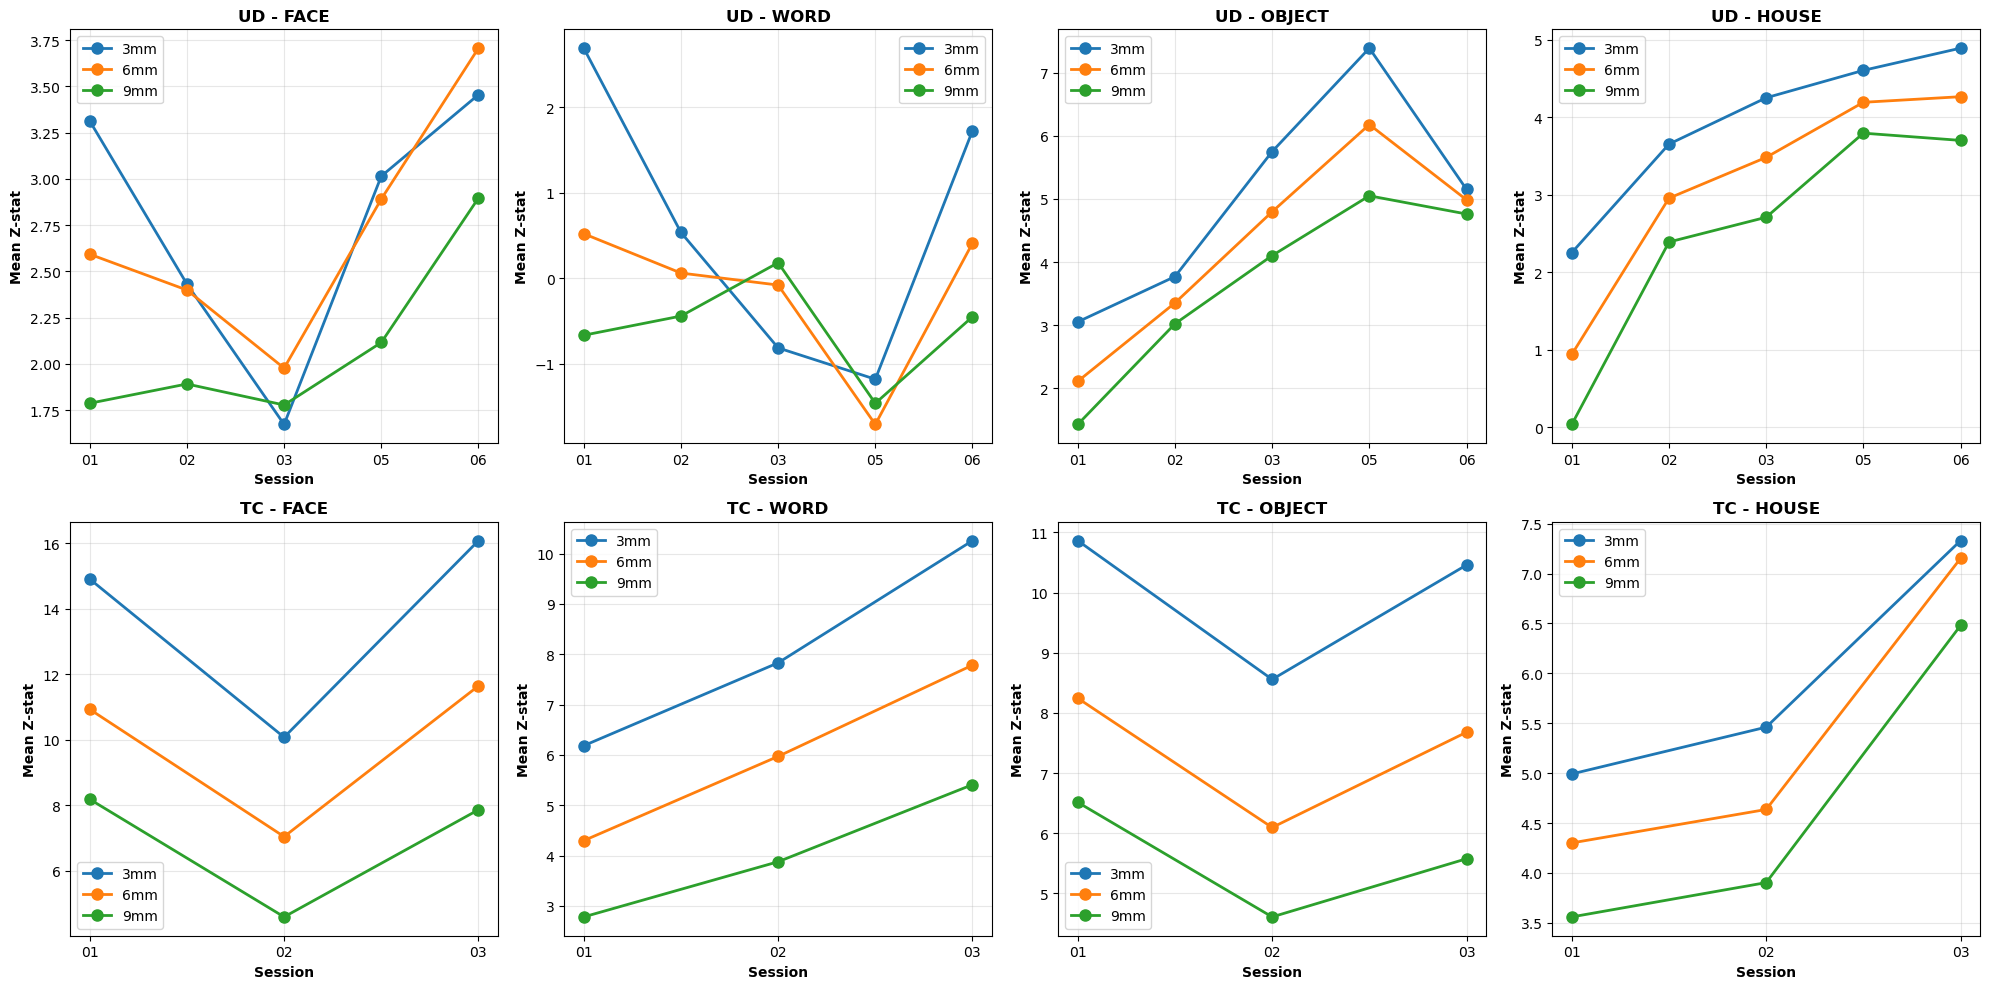

In [31]:
# Visualization: Selectivity in concentric spheres
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, (subj, code) in enumerate([('sub-004', 'UD'), ('sub-021', 'TC')]):
    for col, cat in enumerate(['face', 'word', 'object', 'house']):
        ax = axes[row, col]
        
        results, peak = sphere_results[subj][cat]
        sessions = SUBJECTS[subj]['sessions']
        
        for r in [3, 6, 9]:
            zvals = [results[r][s] for s in sessions if s in results[r]]
            x = np.arange(len(zvals))
            ax.plot(x, zvals, 'o-', label=f'{r}mm', linewidth=2, markersize=8)
        
        ax.set_xlabel('Session', fontweight='bold')
        ax.set_ylabel('Mean Z-stat', fontweight='bold')
        ax.set_title(f'{code} - {cat.upper()}', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(sessions)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'golarai_sphere_selectivity.png', dpi=300, bbox_inches='tight')
plt.show()